In [4]:
import mykeys

mykeys.setOsEnv()

아래 링크를 복사하여 웹 브라우저에 붙여넣으세요.
https://accounts.google.com/o/oauth2/auth?client_id=35726703810-4v13dfqmilhgv6shlc3cv9i3ktuh73j1.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code
Authentication successful.
mykey => set HUGGINGFACEHUB_API_TOKEN is done
mykey => set OPENAI_API_KEY is done
mykey => set LANGCHAIN_API_KEY is done
mykey => set LANGCHAIN_HUB_API_KEY is done
mykey => set GOOGLE_API_KEY is done
mykey => set UPSTAGE_API_KEY is done
mykey => set COHERE_API_KEY is done
mykey => set JINA_API_KEY is done
mykey => set ANTHROPIC_API_KEY is done
mykey => set DEEPL_API_KEY is done
mykey => set TAVILY_API_KEY is done
mykey => set TOGETHER_API_KEY is done


In [6]:
import os

project_name = 'CH17_LangGraph_SUB03'

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = project_name

In [7]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith(project_name)

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17_LangGraph_SUB03


In [ ]:
from langchain_teddynote import logging

# set_enable=False 로 지정하면 추적을 하지 않습니다.
logging.langsmith(project_name, set_enable=False)

CH17 LangGraph

03. Use Cases

01. 에이전트 대화 시뮬레이션 (고객 응대 시나리오)

In [8]:
from langgraph.graph.message import add_messages  
from typing import Annotated  
from typing_extensions import TypedDict  


# State 정의  
class State(TypedDict):  
    messages: Annotated[list, add_messages]  # 사용자 - 상담사 간의 대화 메시지  


In [9]:
from typing import List  
from langchain_teddynote.models import LLMs, get_model_name  
from langchain_openai import ChatOpenAI  
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder  
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage  
from langchain_core.output_parsers import StrOutputParser  

# 모델 이름 설정  
MODEL_NAME = get_model_name(LLMs.GPT4_1)  


def call_chatbot(messages: List[BaseMessage]) -> dict:  
    # LangChain ChatOpenAI 모델을 Agent 로 변경할 수 있습니다.  
    prompt = ChatPromptTemplate.from_messages(  
        [  
            (  
                "system",  
                "You are a customer support agent for an airline. Answer in Korean.",  
            ),  
            MessagesPlaceholder(variable_name="messages"),  
        ]  
    )  
    model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)  
    chain = prompt | model | StrOutputParser()  
    return chain.invoke({"messages": messages})  


In [10]:
call_chatbot([("user", "안녕하세요?")])  


'안녕하세요! 무엇을 도와드릴까요?'

In [11]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder  
from langchain_openai import ChatOpenAI  


def create_scenario(name: str, instructions: str):  
    # 시스템 프롬프트를 정의: 필요에 따라 변경  
    system_prompt_template = """You are a customer of an airline company. \  
You are interacting with a user who is a customer support person. \  

Your name is {name}.  

# Instructions:  
{instructions}  

[IMPORTANT]  
- When you are finished with the conversation, respond with a single word 'FINISHED'  
- You must speak in Korean."""  

    # 대화 메시지와 시스템 프롬프트를 결합하여 채팅 프롬프트 템플릿을 생성합니다.  
    prompt = ChatPromptTemplate.from_messages(  
        [  
            ("system", system_prompt_template),  
            MessagesPlaceholder(variable_name="messages"),  
        ]  
    )  

    # 특정 사용자 이름과 지시사항을 사용하여 프롬프트를 부분적으로 채웁니다.  
    prompt = prompt.partial(name=name, instructions=instructions)  
    return prompt  


In [12]:
# 사용자 지시사항을 정의합니다.  
instructions = """You are tyring to get a refund for the trip you took to Jeju Island. \  
You want them to give you ALL the money back. This trip happened last year."""  

# 사용자 이름을 정의합니다.  
name = "Charlie"  

create_scenario(name, instructions).pretty_print()  


================================ System Message ================================

You are a customer of an airline company. \  
You are interacting with a user who is a customer support person. \  

Your name is {name}.  

# Instructions:  
{instructions}  

[IMPORTANT]  
- When you are finished with the conversation, respond with a single word 'FINISHED'  
- You must speak in Korean.

============================= Messages Placeholder =============================

{messages}


In [13]:
# OpenAI 챗봇 모델을 초기화합니다.  
model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)  

# 시뮬레이션된 사용자 대화를 생성합니다.  
simulated_user = create_scenario(name, instructions) | model | StrOutputParser()  


In [14]:
from langchain_core.messages import HumanMessage  

# 시뮬레이션된 사용자에게 메시지를 전달  
messages = [HumanMessage(content="안녕하세요? 어떻게 도와 드릴까요?")]  
simulated_user.invoke({"messages": messages})  


'안녕하세요. 저는 작년에 제주도에 다녀온 여행에 대한 환불을 받고 싶어서 연락드렸습니다. 전액 환불을 원합니다. 어떻게 해야 하나요?'

In [15]:
from langchain_core.messages import AIMessage  


# 상담사 역할  
def ai_assistant_node(messages):  
    # 상담사 응답 호출  
    ai_response = call_chatbot(messages)  

    # AI 상담사의 응답을 반환  
    return {"messages": [("assistant", ai_response)]}  


In [16]:
ai_assistant_node(  
    [  
        ("user", "안녕하세요?"),  
        ("assistant", "안녕하세요! 어떻게 도와드릴까요?"),  
        ("user", "환불 어떻게 하나요?"),  
    ]  
)  


{'messages': [('assistant',
   '환불을 원하시는 경우, 아래 절차를 따라주시면 됩니다.\n\n1. **항공권 예매 내역 확인**: 예매하신 항공권의 예약번호(PNR)와 승객 성함을 준비해 주세요.\n2. **구매 경로 확인**: 공식 홈페이지, 모바일 앱, 여행사 등 어떤 경로로 예매하셨는지 확인해 주세요.\n3. **환불 신청**:  \n   - 공식 홈페이지 또는 모바일 앱: [내 예약] 메뉴에서 환불 신청이 가능합니다.\n   - 여행사 예매: 예매하신 여행사로 문의해 주세요.\n   - 고객센터 전화: 저희 고객센터(☎️)로 연락 주시면 안내해 드립니다.\n\n**유의사항**:  \n- 항공권 종류(환불 가능/불가)에 따라 환불 규정 및 수수료가 다를 수 있습니다.  \n- 일부 할인 항공권은 환불이 불가능할 수 있습니다.  \n- 결제하신 수단으로 환불 처리되며, 영업일 기준 5~7일 정도 소요될 수 있습니다.\n\n예약번호와 성함을 알려주시면, 보다 자세히 안내해 드릴 수 있습니다. 추가로 궁금하신 점 있으시면 언제든 문의해 주세요!')]}

In [17]:
def _swap_roles(messages):  
    # 메시지의 역할을 교환: 시뮬레이션 사용자 단계에서 메시지 타입을 AI -> Human, Human -> AI 로 교환합니다.  
    new_messages = []  
    for m in messages:  
        if isinstance(m, AIMessage):  
            # AIMessage 인 경우, HumanMessage 로 변환합니다.  
            new_messages.append(HumanMessage(content=m.content))  
        else:  
            # HumanMessage 인 경우, AIMessage 로 변환합니다.  
            new_messages.append(AIMessage(content=m.content))  
    return new_messages  


# 상담사 역할(AI Assistant) 노드 정의  
def ai_assistant_node(state: State):  
    # 상담사 응답 호출  
    ai_response = call_chatbot(state["messages"])  

    # AI 상담사의 응답을 반환  
    return {"messages": [("assistant", ai_response)]}  


# 시뮬레이션된 사용자(Simulated User) 노드 정의  
def simulated_user_node(state: State):  
    # 메시지 타입을 교환: AI -> Human, Human -> AI  
    new_messages = _swap_roles(state["messages"])  

    # 시뮬레이션된 사용자를 호출  
    response = simulated_user.invoke({"messages": new_messages})  
    return {"messages": [("user", response)]}  


In [18]:
def should_continue(state: State):  
    # 메시지 리스트의 길이가 6보다 크면 'end'를 반환합니다.  
    if len(state["messages"]) > 6:  
        return "end"  
    # 마지막 메시지의 내용이 'FINISHED'라면 'end'를 반환합니다.  
    elif state["messages"][-1].content == "FINISHED":  
        return "end"  
    # 위의 조건에 해당하지 않으면 'continue'를 반환합니다.  
    else:  
        return "continue"  


In [19]:
from langgraph.graph import END, StateGraph  

# StateGraph 인스턴스 생성  
graph_builder = StateGraph(State)  

# 노드 정의  
graph_builder.add_node("simulated_user", simulated_user_node)  
graph_builder.add_node("ai_assistant", ai_assistant_node)  

# 엣지 정의 (챗봇 -> 시뮬레이션된 사용자)  
graph_builder.add_edge("ai_assistant", "simulated_user")  

# 조건부 엣지 정의  
graph_builder.add_conditional_edges(  
    "simulated_user",  
    should_continue,  
    {  
        "end": END,  # 종료 조건이 충족되면 시뮬레이션을 중단  
        "continue": "ai_assistant",  # 종료 조건이 충족되지 않으면 상담사 역할 노드로 메시지를 전달  
    },  
)  

# 시작점 설정  
graph_builder.set_entry_point("ai_assistant")  

# 그래프 컴파일  
simulation = graph_builder.compile()  


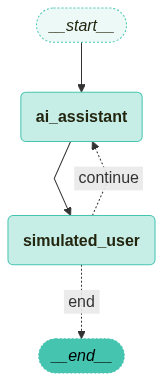

In [20]:
from langchain_teddynote.graphs import visualize_graph  

visualize_graph(simulation)  


In [21]:
from langchain_core.runnables import RunnableConfig  
from langchain_teddynote.messages import stream_graph, random_uuid  


# config 설정(재귀 최대 횟수, thread_id)  
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})  

# 입력 메시지 설정  
inputs = {  
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]  
}  

# 그래프 스트리밍  
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])  



🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요, 고객님. 불편을 드려 정말 죄송합니다. 어떤 문제로 인해 화가 나셨는지 말씀해 주시면, 최대한 빠르고 성심껏 도와드리겠습니다. 자세한 상황을 알려주시면 감사하겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
지난해 제주도 여행을 다녀왔는데, 정말 최악이었어요. 비행기가 계속 지연되고, 서비스도 너무 별로였고, 수하물도 늦게 나와서 일정이 다 망가졌어요. 이런 경우 전액 환불 받을 수 있죠?
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
고객님, 우선 지난해 여행에서 많은 불편을 겪으신 점 진심으로 사과드립니다. 말씀해주신 비행기 지연, 서비스 문제, 수하물 지연 등으로 인해 여행 일정에 큰 차질이 생기셨던 점 충분히 이해하고 있습니다.

다만, 전액 환불 가능 여부는 항공권 종류(환불 가능/불가), 지연 시간, 당시의 정확한 상황(기상, 항공사 귀책 등)에 따라 달라질 수 있습니다. 일반적으로 항공편 지연이나 수하물 지연만으로 전액 환불이 바로 진행되진 않지만, 보상 또는 일부 환불, 마일리지, 바우처 등으로 지원이 가능한 경우도 있습니다.

정확한 안내를 위해 예약하셨던 항공권의 예약번호나 성함, 당시 상황(지연 시간, 수하물 수령 시간 등)을 알려주시면 확인 후 최대한 도움드릴 수 있도록 하겠습니다. 추가 정보를 남겨주시면 바로 확인해드리겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
저는 Charlie이고, 예약번호는 JEJU1234입니다.  
그날 비행기가 4시간 넘게 지연됐고, 수하물도 2시간이나 기다렸어요.  
여행 첫날 일정이 

02. 사용자 요구사항 기반 메타 프롬프트 생성 에이전트

In [22]:
from typing import List
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_teddynote.models import get_model_name, LLMs

# 사용자 요구사항 수집을 위한 시스템 메시지 템플릿
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool.

[IMPORTANT] Your conversation should be in Korean. Your generated prompt should be in English."""


# 사용자 메시지 목록을 받아 시스템 메시지와 결합하여 반환
def get_messages_info(messages):
    # 사용자 요구사항 수집을 위한 시스템 메시지와 기존 메시지 결합
    return [SystemMessage(content=template)] + messages


# LLM에 대한 프롬프트 지침을 정의하는 데이터 모델
class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    # 프롬프트의 목표
    objective: str
    # 프롬프트 템플릿에 전달될 변수 목록
    variables: List[str]
    # 출력에서 피해야 할 제약 조건 목록
    constraints: List[str]
    # 출력이 반드시 따라야 할 요구 사항 목록
    requirements: List[str]


# 최신 LLM 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4_1)
# LLM 초기화
llm = ChatOpenAI(temperature=0, model=MODEL_NAME)
# PromptInstructions 구조체를 바인딩
llm_with_tool = llm.bind_tools([PromptInstructions])


# 상태 정보를 기반으로 메시지 체인을 생성하고 LLM 호출
def info_chain(state):
    # 상태에서 메시지 정보를 가져와 시스템 메시지와 결합
    messages = get_messages_info(state["messages"])
    # LLM을 호출하여 응답 생성
    response = llm_with_tool.invoke(messages)
    # 생성된 응답을 메시지 목록으로 반환
    return {"messages": [response]}


In [23]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# 프롬프트를 생성하는 메타 프롬프트 정의
META_PROMPT = """Given a task description or existing prompt, produce a detailed system prompt to guide a language model in completing the task effectively.

# Guidelines

- Understand the Task: Grasp the main objective, goals, requirements, constraints, and expected output.
- Minimal Changes: If an existing prompt is provided, improve it only if it's simple. For complex prompts, enhance clarity and add missing elements without altering the original structure.
- Reasoning Before Conclusions**: Encourage reasoning steps before any conclusions are reached. ATTENTION! If the user provides examples where the reasoning happens afterward, REVERSE the order! NEVER START EXAMPLES WITH CONCLUSIONS!
    - Reasoning Order: Call out reasoning portions of the prompt and conclusion parts (specific fields by name). For each, determine the ORDER in which this is done, and whether it needs to be reversed.
    - Conclusion, classifications, or results should ALWAYS appear last.
- Examples: Include high-quality examples if helpful, using placeholders [in brackets] for complex elements.
   - What kinds of examples may need to be included, how many, and whether they are complex enough to benefit from placeholders.
- Clarity and Conciseness: Use clear, specific language. Avoid unnecessary instructions or bland statements.
- Formatting: Use markdown features for readability. DO NOT USE ``` CODE BLOCKS UNLESS SPECIFICALLY REQUESTED.
- Preserve User Content: If the input task or prompt includes extensive guidelines or examples, preserve them entirely, or as closely as possible. If they are vague, consider breaking down into sub-steps. Keep any details, guidelines, examples, variables, or placeholders provided by the user.
- Constants: DO include constants in the prompt, as they are not susceptible to prompt injection. Such as guides, rubrics, and examples.
- Output Format: Explicitly the most appropriate output format, in detail. This should include length and syntax (e.g. short sentence, paragraph, JSON, etc.)
    - For tasks outputting well-defined or structured data (classification, JSON, etc.) bias toward outputting a JSON.
    - JSON should never be wrapped in code blocks (```) unless explicitly requested.

The final prompt you output should adhere to the following structure below. Do not include any additional commentary, only output the completed system prompt. SPECIFICALLY, do not include any additional messages at the start or end of the prompt. (e.g. no "---")

[Concise instruction describing the task - this should be the first line in the prompt, no section header]

[Additional details as needed.]

[Optional sections with headings or bullet points for detailed steps.]

# Steps [optional]

[optional: a detailed breakdown of the steps necessary to accomplish the task]

# Output Format

[Specifically call out how the output should be formatted, be it response length, structure e.g. JSON, markdown, etc]

[User given variables should be wrapped in {{brackets}}]

<Question>
{{question}}
</Question>

<Answer>
{{answer}}
</Answer>

# Examples [optional]

[Optional: 1-3 well-defined examples with placeholders if necessary. Clearly mark where examples start and end, and what the input and output are. User placeholders as necessary.]
[If the examples are shorter than what a realistic example is expected to be, make a reference with () explaining how real examples should be longer / shorter / different. AND USE PLACEHOLDERS! ]

# Notes [optional]

[optional: edge cases, details, and an area to call or repeat out specific important considerations]

# Based on the following requirements, write a good prompt template:

{reqs}
"""


# 프롬프트 생성을 위한 메시지 가져오기 함수
# 도구 호출 이후의 메시지만 가져옴
def get_prompt_messages(messages: list):
    # 도구 호출 정보를 저장할 변수 초기화
    tool_call = None
    # 도구 호출 이후의 메시지를 저장할 리스트 초기화
    other_msgs = []
    # 메시지 목록을 순회하며 도구 호출 및 기타 메시지 처리
    for m in messages:
        # AI 메시지 중 도구 호출이 있는 경우 도구 호출 정보 저장
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        # ToolMessage는 건너뜀
        elif isinstance(m, ToolMessage):
            continue
        # 도구 호출 이후의 메시지를 리스트에 추가
        elif tool_call is not None:
            other_msgs.append(m)
    # 시스템 메시지와 도구 호출 이후의 메시지를 결합하여 반환
    return [SystemMessage(content=META_PROMPT.format(reqs=tool_call))] + other_msgs


# 프롬프트 생성 체인 함수 정의
def prompt_gen_chain(state):
    # 상태에서 프롬프트 메시지를 가져옴
    messages = get_prompt_messages(state["messages"])
    # LLM을 호출하여 응답 생성
    response = llm.invoke(messages)
    # 생성된 응답을 메시지 목록으로 반환
    return {"messages": [response]}


In [24]:
from langgraph.graph import END


# 상태 결정 함수 정의
# 상태에서 메시지 목록을 가져옴
def get_state(state):
    messages = state["messages"]
    # 마지막 메시지가 AIMessage이고 도구 호출이 있는 경우
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        # 도구 메시지를 추가해야 하는 상태 반환
        return "add_tool_message"
    # 마지막 메시지가 HumanMessage가 아닌 경우
    elif not isinstance(messages[-1], HumanMessage):
        # 대화 종료 상태 반환
        return END
    # 기본적으로 정보 수집 상태 반환
    return "info"


In [25]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import ToolMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


# State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 메모리에 대화 기록을 저장하기 위한 MemorySaver 초기화
memory = MemorySaver()

# 상태 그래프 초기화
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


# 도구 메시지 추가 상태 노드 정의
@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0][
                    "id"
                ],  # 상태에서 도구 호출 ID를 가져와 메시지에 추가
            )
        ]
    }


# 조건부 상태 전환 정의
workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])

# 엣지 정의
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

# 그래프 컴파일
graph = workflow.compile(checkpointer=memory)


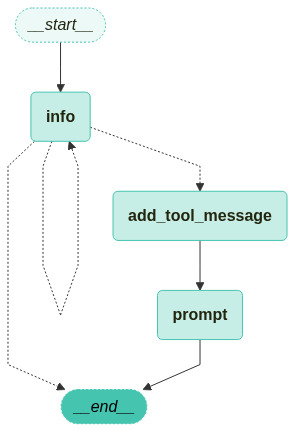

In [26]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)


In [28]:
import uuid
from langchain_teddynote.messages import stream_graph

# 구성 설정 초기화 (고유한 thread_id 생성)
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# 무한 루프 시작
while True:
    try:
        # 사용자 입력 받기
        user = input("User (q/Q to quit): ")
    except:
        pass

    # 사용자 입력 출력
    print(f"\n[사용자] {user}")

    # 'q' 또는 'Q' 입력 시 루프 종료
    if user in {"q", "Q"}:
        print("AI: 다음에 또 만나요!")
        break

    # 출력 변수 초기화
    output = None

    stream_graph(
        graph,
        {"messages": [HumanMessage(content=user)]},
        config=config,
        node_names=["info", "prompt"],
    )



[사용자] 

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! 어떤 종류의 프롬프트 템플릿을 만들고 싶으신가요?

아래 정보를 알려주시면 맞춤형 프롬프트를 만들어드릴 수 있습니다:
1. 프롬프트의 목적(목표)은 무엇인가요?
2. 프롬프트에 어떤 변수(입력값)가 들어가야 하나요?
3. 출력 결과에서 반드시 피해야 할(하지 말아야 할) 점이 있나요?
4. 출력 결과가 반드시 지켜야 할 요구사항이 있나요?

자세히 설명해주시면 더 좋은 결과를 드릴 수 있습니다!
[사용자] 광고용으로 사용할 아주 귀엽고 사랑스러운 고양이 털은 복슬복슬하고 길면안돼 살은 적당이 있어야돼

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
좋은 정보 감사합니다! 몇 가지 추가로 확인하고 싶습니다.

1. 프롬프트의 목적: 광고용으로 사용할 귀엽고 사랑스러운 고양이 묘사(설명)를 생성하는 것이 맞나요? 아니면 이미지 생성, 슬로건, 문구 등 다른 목적이 있으신가요?
2. 변수: 프롬프트에 포함되어야 할 변수(예: 고양이의 색상, 나이, 성격 등)가 있다면 알려주세요.
3. 출력에서 반드시 피해야 할 점: "털이 복슬복슬하고 길면 안 된다"는 점을 명확히 이해했습니다. 혹시 추가로 피해야 할 점이 있을까요?
4. 출력에서 반드시 지켜야 할 요구사항: "살이 적당히 있어야 한다" 외에 추가로 꼭 들어가야 할 요소가 있을까요? 예를 들어, 특정 분위기, 감정, 단어 사용 등.

조금만 더 구체적으로 알려주시면 최적의 프롬프트를 만들어드릴 수 있습니다!
[사용자] 삼색냥이로 해줘

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
감사합니다! 정리해서 확인드릴게요.

1. 목적: 광고용으로 사용할 아주 귀엽고 사랑스러운 고양이(삼색냥이)를 묘사하는 프롬프트
2. 변수: 삼색 고양

03. CRAG(Corrective RAG)

In [29]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever 와 chain을 생성
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


In [30]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs
from pydantic import BaseModel, Field

# 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4_1)


# 검색된 문서의 관련성 여부를 이진 점수로 평가하는 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved document."""

    # 문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# GradeDocuments 데이터 모델을 사용하여 구조화된 출력을 생성하는 LLM
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 채팅 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Retrieval 평가기 초기화
retrieval_grader = grade_prompt | structured_llm_grader


In [31]:
# 질문 정의
question = "삼성전자가 개발한 생성AI 에 대해 설명하세요."

# 문서 검색
docs = pdf_retriever.invoke(question)

# 검색된 문서 중 1번 index 문서의 페이지 내용을 추출
doc_txt = docs[1].page_content

# 검색된 문서와 질문을 사용하여 관련성 평가를 실행하고 결과 출력
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


binary_score='yes'


In [32]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI


# LangChain Hub에서 RAG 프롬프트를 가져와 사용
prompt = hub.pull("teddynote/rag-prompt")

# LLM 초기화
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# 체인 생성
rag_chain = prompt | llm | StrOutputParser()


# 체인 실행 및 결과 출력
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)


삼성전자가 개발한 생성AI는 ‘삼성 가우스(Samsung Gauss)’로, 언어 모델, 코드 모델, 이미지 모델의 3개 모델로 구성되어 있다. 삼성 가우스는 온디바이스(On-device)에서 작동 가능하며, 외부로 사용자 정보가 유출될 위험이 없는 것이 특징이다. 언어 모델은 메일 작성, 문서 요약, 번역 업무를 지원하고, 코드 모델은 AI 코딩 어시스턴트 ‘코드아이(code.i)’로 사내 소프트웨어 개발에 최적화되어 있다. 이미지 모델은 창의적 이미지 생성, 이미지 변환, 저해상도 이미지의 고해상도 전환을 지원한다. 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획이다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (p.13)


In [33]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LLM 설정
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Query Rewrite 시스템 프롬프트
system = """You a question re-writer that converts an input question to a better version that is optimized 
for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

# 프롬프트 정의
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Question Re-writer 체인 초기화
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [34]:
# 실행 및 결과 확인
print(f'[원본 질문]: "{question}"')
print("[쿼리 재작성]:", question_rewriter.invoke({"question": question}))


[원본 질문]: "삼성전자가 개발한 생성AI 에 대해 설명하세요."
[쿼리 재작성]: 삼성전자가 개발한 생성 AI의 주요 특징과 활용 사례는 무엇인가요?


In [35]:
# 웹 검색 도구 초기화
from langchain_teddynote.tools.tavily import TavilySearch

# 최대 검색 결과를 3으로 설정
web_search_tool = TavilySearch(max_results=3)


In [36]:
# 웹 검색 도구 실행
results = web_search_tool.invoke({"query": question})
print(results)


[{'url': 'https://v.daum.net/v/20241121100020817', 'title': "삼성전자, 자체 개발한 생성형 AI '삼성 가우스2' 공개 - Daum", 'content': '### 삼성전자, 자체 개발한 생성형 AI \'삼성 가우스2\' 공개 또한 "삼성전자 고유의 생성형 AI 모델인 \'삼성 가우스2\'를 공개하고, 향상된 성능과 효율, 그리고 활용 방안에 대해 설명할 예정"이라며 "이를 통해 업무 생산성 향상과 단계적 제품 적용으로 더욱 편리하고 차별화된 고객 경험을 제공할 것"이라고 말했다. 삼성전자는 키노트 발표에서 지난해 처음 공개한 생성형 AI 모델 \'삼성 가우스1(Samsung Gauss1)\'의 후속 모델인 \'삼성 가우스2(Samsung Gauss2)\'를 공개했다. 삼성 가우스 포탈(Samsung Gauss Portal)은 \'삼성 가우스\'의 대화형 AI 서비스로 ▲문서 요약 ▲번역 ▲메일 작성 등 DX부문 직원들의 다양한 사무 업무를 빠르고 효율적으로 처리할 수 있도록 지원하고 있다. 삼성전자는 향후 \'삼성 가우스2\'를 통해 \'코드아이(code.i)\'서비스의 지속적인 성능 개선, \'삼성 가우스 포탈(Samsung Gauss Portal)\'의 자연어 질의응답 성능 향상, 표와 차트의 이해, 이미지 생성 등 멀티모달 기능을 지원해 사내 생산성 향상에 기여할 계획이다.', 'score': 0.83549726, 'raw_content': '# [지디넷코리아](https://v.daum.net/channel/294/home)\n\n## 검색\n\n검색\n\n\n\n## 속보\n\n### 삼성전자, 자체 개발한 생성형 AI \'삼성 가우스2\' 공개\n\n장경윤 기자 2024. 11. 21. 10:00\n\n**음성재생 설정**\n\n[닫기](#none)\n\n**번역*beta*** Translated by [kaka i](https://kakao.ai/)\n\n[닫기](#none)\n\n**번역중** N

In [37]:
from typing import Annotated, List
from typing_extensions import TypedDict


# 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "The question to answer"]
    generation: Annotated[str, "The generation from the LLM"]
    web_search: Annotated[str, "Whether to add search"]
    documents: Annotated[List[str], "The documents retrieved"]


In [38]:
from langchain.schema import Document


# 문서 검색 노드
def retrieve(state: GraphState):
    print("\n==== RETRIEVE ====\n")
    question = state["question"]

    # 문서 검색 수행
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# 답변 생성 노드
def generate(state: GraphState):
    print("\n==== GENERATE ====\n")
    question = state["question"]
    documents = state["documents"]

    # RAG를 사용한 답변 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# 문서 평가 노드
def grade_documents(state: GraphState):
    print("\n==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====\n")
    question = state["question"]
    documents = state["documents"]

    # 필터링된 문서
    filtered_docs = []
    relevant_doc_count = 0

    for d in documents:
        # Question-Document 의 관련성 평가
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score

        if grade == "yes":
            print("==== [GRADE: DOCUMENT RELEVANT] ====")
            # 관련 있는 문서를 filtered_docs 에 추가
            filtered_docs.append(d)
            relevant_doc_count += 1
        else:
            print("==== [GRADE: DOCUMENT NOT RELEVANT] ====")
            continue

    # 관련 문서가 없으면 웹 검색 수행
    web_search = "Yes" if relevant_doc_count == 0 else "No"
    return {"documents": filtered_docs, "web_search": web_search}


# 쿼리 재작성 노드
def query_rewrite(state: GraphState):
    print("\n==== [REWRITE QUERY] ====\n")
    question = state["question"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


# 웹 검색 노드
def web_search(state: GraphState):
    print("\n==== [WEB SEARCH] ====\n")
    question = state["question"]
    documents = state["documents"]

    # 웹 검색 수행
    docs = web_search_tool.invoke({"query": question})
    # 검색 결과를 문서 형식으로 변환
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents}


In [39]:
def decide_to_generate(state: GraphState):
    # 평가된 문서를 기반으로 다음 단계 결정
    print("==== [ASSESS GRADED DOCUMENTS] ====")
    # 웹 검색 필요 여부
    web_search = state["web_search"]

    if web_search == "Yes":
        # 웹 검색으로 정보 보강이 필요한 경우
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ===="
        )
        # 쿼리 재작성 노드로 라우팅
        return "query_rewrite"
    else:
        # 관련 문서가 존재하므로 답변 생성 단계(generate) 로 진행
        print("==== [DECISION: GENERATE] ====")
        return "generate"


In [40]:
from langgraph.graph import END, StateGraph, START

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("web_search_node", web_search)

# 엣지 연결
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "query_rewrite": "query_rewrite",
        "generate": "generate",
    },
)

# 엣지 연결
workflow.add_edge("query_rewrite", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# 그래프 컴파일
app = workflow.compile()


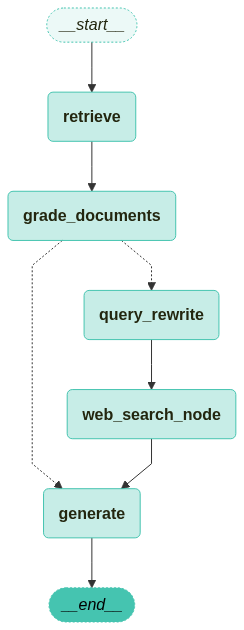

In [41]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


In [42]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

# 스트리밍 형식으로 그래프 실행
stream_graph(
    app,
    inputs,
    config,
    ["retrieve", "grade_documents", "query_rewrite", "web_search_node", "generate"],
)



==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"binary_score":"yes"}==== [GRADE: DOCUMENT RELEVANT] ====
{"binary_score":"yes"}==== [GRADE: DOCUMENT RELEVANT] ====
{"binary_score==== [GRADE: DOCUMENT RELEVANT] ====
":"yes"}{"binary_score":"yes"}==== [GRADE: DOCUMENT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"yes"}==== [GRADE: DOCUMENT RELEVANT] ====
{"binary_score":"yes"}==== [GRADE: DOCUMENT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: GENERATE] ====

==== GENERATE ====


🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자가 개발한 생성형 AI의 이름은 ‘삼성 가우스’이다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (p.12)

In [43]:
# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "2024년 노벨문학상 수상자의 이름은?",
}


In [44]:
# 그래프 실행
invoke_graph(app, inputs, config)



==== RETRIEVE ====


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='CES 2024
이번 전시에는 500곳 이상의 한국기업 참가 예정
기간 장소 홈페이지
2024.1.9~12 미국, 라스베가스 https://www.ces.tech/
- 머신러닝 및 응용에 관한 국제 컨퍼런스(AIMLA 2024)는
인공지능 및 머신러닝의 이론, 방법론 및 실용적 접근에 관한
지식과 최신 연구 결과 공유
- 이론 및 실무 측면에서 인공지능, 기계학습의 주요 분야를
논의하고, 학계, 산업계의 연구자와 실무자들에게 해당 분
AIMLA 2024
야의 최첨단 개발 소식 공유
기간 장소 홈페이지' metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 21, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}
page_content='n 참가국들은 튜링상을 수상한 AI 학자인 요슈아 벤지오 교수가 주도하는 ‘과학의 현황(State of
the Science)’ 보고서 작성에도 합의했으며, 보고서를 통해 첨단 AI의 위험과 가능성에 관한
기존 연구를 과학적으로 평가하고 향후 AI 안전 연구를 위한 우선순위를 제시할 계획
n 한국은 영국 정부와 6개월 뒤에 온라인으로 AI 미니 정상회의를 공동 개최하기로 합의했으며,
프랑스 정부와는 1년 후 대면 정상회의를 개최할 예정' metadata={'source':

In [45]:
# 그래프 실행
stream_graph(
    app,
    inputs,
    config,
    ["retrieve", "grade_documents", "query_rewrite", "generate"],
)



==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
{"binary_score":"no==== [GRADE: DOCUMENT NOT RELEVANT] ====
"}{"binary_score":"no"}==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ====

==== [REWRITE QUERY] ====


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 노벨문학

04. Self-RAG

In [46]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


In [50]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# 최신모델 이름 설정
MODEL_NAME = get_model_name(LLMs.GPT4_1)


# 데이터 모델 정의: 검색된 문서의 관련성을 이진 점수로 평가하기 위한 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved documents."""

    # 문서가 질문에 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# GradeDocuments 데이터 모델을 사용하여 LLM의 구조화된 출력 생성
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의: 검색된 문서가 사용자 질문에 관련이 있는지 평가하는 시스템 역할 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 채팅 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 검색 평가기 생성
retrieval_grader = grade_prompt | structured_llm_grader


In [51]:
# 질문 정의
question = "삼성전자가 개발한 생성형 AI 의 이름은?"

# 문서 검색
docs = pdf_retriever.invoke(question)

# 검색된 문서 중 두 번째 문서의 페이지 콘텐츠 추출
doc_txt = docs[1].page_content

# 검색 평가기 호출 및 결과 출력
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


binary_score='yes'


In [52]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# LangChain Hub에서 프롬프트 가져오기
prompt = hub.pull("teddynote/rag-prompt")

# 기본 LLM 초기화, 모델 이름과 온도 설정
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# RAG 체인 생성
rag_chain = prompt | llm | StrOutputParser()

# 체인 실행
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)


삼성전자가 개발한 생성형 AI의 이름은 ‘삼성 가우스’(Samsung Gauss)이다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (p.13)


In [53]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# 데이터 모델 정의: 생성된 답변이 사실에 기반하고 있는지 여부를 이진 점수로 평가하기 위한 데이터 모델
class Groundednesss(BaseModel):
    """A binary score indicating whether the generated answer is grounded in the facts."""

    # 답변이 사실에 기반하고 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 구조화된 출력과 함께 LLM 설정
structured_llm_grader = llm.with_structured_output(Groundednesss)

# 시스템 프롬프트 정의
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 채팅 프롬프트 템플릿 생성
groundedness_checking_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# 답변의 할루시네이션 평가기 생성
groundedness_grader = groundedness_checking_prompt | structured_llm_grader


In [54]:
# 할루시네이션 평가기 호출(yes: 사실에 기반하고 있음, no: 사실에 기반하고 있지 않음)
groundedness_grader.invoke({"documents": format_docs(docs), "generation": generation})


Groundednesss(binary_score='yes')

In [55]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


class GradeAnswer(BaseModel):
    """A binary score indicating whether the question is addressed."""

    # 답변의 관련성 평가: 'yes' 또는 'no'로 표기(yes: 관련성 있음, no: 관련성 없음)
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# llm 에 GradeAnswer 바인딩
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# 시스템 프롬프트 정의
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# 프롬프트 생성
answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 답변 평가기 생성
answer_grader = answer_grader_prompt | structured_llm_grader


In [56]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 시스템 프롬프트 정의
# 입력 질문을 벡터스토어 검색에 최적화된 형태로 변환하는 시스템 역할 정의
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

# 시스템 메시지와 초기 질문을 포함한 프롬프트 템플릿 생성
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# 질문 재작성기 생성
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [57]:
# 질문 재작성기 호출
question_rewriter.invoke({"question": question})


'삼성전자가 개발한 생성형 인공지능(AI) 모델의 공식 명칭은 무엇인가?'

In [58]:
from typing import List
from typing_extensions import TypedDict, Annotated


# 그래프의 상태를 나타내는 클래스 정의
class GraphState(TypedDict):
    # 질문을 나타내는 문자열
    question: Annotated[str, "Question"]
    # LLM에 의해 생성된 응답을 나타내는 문자열
    generation: Annotated[str, "LLM Generation"]
    # 문서의 목록을 나타내는 문자열 리스트
    documents: Annotated[List[str], "Retrieved Documents"]


In [59]:
# 문서 검색
def retrieve(state):
    print("==== [RETRIEVE] ====")
    question = state["question"]

    # 검색 수행
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# 답변 생성
def generate(state):
    print("==== [GENERATE] ====")
    question = state["question"]
    documents = state["documents"]

    # RAG 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# 검색된 문서의 관련성 평가
def grade_documents(state):
    print("==== [GRADE DOCUMENTS] ====")
    question = state["question"]
    documents = state["documents"]

    # 각 문서 점수 평가
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("==== GRADE: DOCUMENT RELEVANT ====")
            filtered_docs.append(d)
        else:
            print("==== GRADE: DOCUMENT NOT RELEVANT ====")
            continue
    return {"documents": filtered_docs}


# 질문 변환
def transform_query(state):
    print("==== [TRANSFORM QUERY] ====")
    question = state["question"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


In [60]:
# 답변 생성 여부 결정
def decide_to_generate(state):
    print("==== [ASSESS GRADED DOCUMENTS] ====")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 관련성이 없는 경우
        # 새로운 쿼리 생성
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # 관련 문서가 있는 경우 답변 생성
        print("==== [DECISION: GENERATE] ====")
        return "generate"


# 생성된 답변의 문서 및 질문과의 관련성 평가
def grade_generation_v_documents_and_question(state):
    print("==== [CHECK HALLUCINATIONS] ====")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = groundedness_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # 환각 여부 확인
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")
        # 질문 해결 여부 확인
        print("==== [GRADE GENERATION vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("==== [DECISION: GENERATION ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATION DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"


In [61]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# 엣지 정의
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

# 엣지 정의
workflow.add_edge("transform_query", "retrieve")

# 답변 생성 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "hallucination": "generate",
        "relevant": END,
        "not relevant": "transform_query",
    },
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())


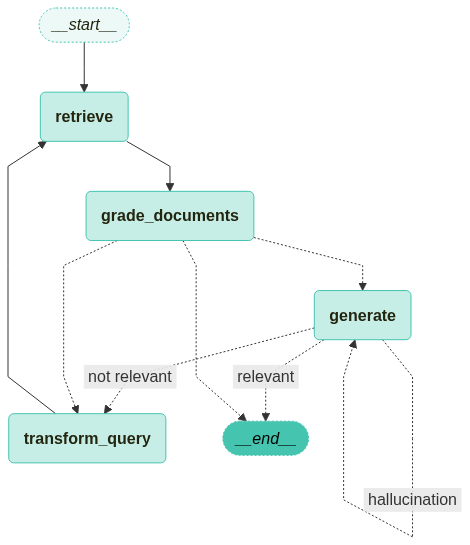

In [62]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


In [63]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

# 그래프 실행
invoke_graph(
    app, inputs, config, ["retrieve", "transform_query", "grade_documents", "generate"]
)


==== [RETRIEVE] ====

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원' metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}
page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'

In [64]:
from langgraph.errors import GraphRecursionError

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "테디노트가 개발한 생성형 AI 의 이름은?",
}

try:
    # 그래프 실행
    stream_graph(
        app,
        inputs,
        config,
        ["retrieve", "transform_query", "grade_documents", "generate"],
    )
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


==== [RETRIEVE] ====
==== [GRADE DOCUMENTS] ====

🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"binary_score":"no"}==== GRADE: DOCUMENT NOT RELEVANT ====
{"binary_score":"no"}==== GRADE: DOCUMENT NOT RELEVANT ====
{"binary_score":"no"}==== GRADE: DOCUMENT NOT RELEVANT ====
{"binary_score":"no"}==== GRADE: DOCUMENT NOT RELEVANT ====
{"binary_score":"no"}==== GRADE: DOCUMENT NOT RELEVANT ====
{"binary_score":"==== GRADE: DOCUMENT NOT RELEVANT ====
no"}{"binary_score":"no==== GRADE: DOCUMENT NOT RELEVANT ====
"}{"binary_score":"no"}==== GRADE: DOCUMENT NOT RELEVANT ====
{"binary_score":"no"}==== GRADE: DOCUMENT NOT RELEVANT ====
{"binary_score":"no"}==== GRADE: DOCUMENT NOT RELEVANT ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ====
==== [TRANSFORM QUERY] ====

🔄 Node: transform_query 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
테디노트가 개발한 생성형 인공지능(AI)의 공식 명칭은 무엇인가요?==== [RETRIE

05. 계획 후 실행(Plan-and-Execute)

In [72]:
from langchain_teddynote.models import get_model_name, LLMs

# 모델명 정의
MODEL_NAME = get_model_name(LLMs.GPT4_1)
print(MODEL_NAME)


gpt-4.1


In [73]:
from langchain_teddynote.tools import TavilySearch

# Tavily 검색 도구 초기화
tools = [TavilySearch(max_results=3)]


In [74]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 정의
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer in Korean.",
        ),
        ("human", "{messages}"),
    ]
)


# LLM 정의
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# ReAct 에이전트 생성
agent_executor = create_react_agent(llm, tools, prompt=prompt)


In [75]:
# 에이전트 실행
agent_executor.invoke(
    {"messages": [("user", "랭체인 한국어 튜토리얼에 대해서 설명해줘")]}
)


{'messages': [HumanMessage(content='랭체인 한국어 튜토리얼에 대해서 설명해줘', additional_kwargs={}, response_metadata={}, id='ab40a1bb-783c-4835-a938-168e8316ab2f'),
  AIMessage(content='랭체인(LangChain)은 자연어 처리(NLP)와 인공지능(AI) 애플리케이션을 쉽게 만들 수 있도록 도와주는 파이썬 기반의 오픈소스 프레임워크입니다. 특히 챗봇, 문서 요약, 질의응답 시스템 등 다양한 LLM(대형 언어 모델) 기반 서비스를 개발할 때 많이 사용됩니다.\n\n한국어 튜토리얼에 대해 간단히 설명드리면 다음과 같습니다.\n\n1. 랭체인 기본 개념\n- 랭체인은 LLM(예: GPT-3, GPT-4 등)과 다양한 데이터 소스(문서, 웹, 데이터베이스 등)를 연결해주는 역할을 합니다.\n- 체인(Chain), 에이전트(Agent), 프롬프트(Prompt) 등 여러 컴포넌트로 구성되어 있습니다.\n\n2. 설치 방법\n- pip install langchain 명령어로 설치할 수 있습니다.\n- OpenAI API 키 등 LLM을 사용하기 위한 환경설정이 필요합니다.\n\n3. 기본 사용법\n- 프롬프트 템플릿을 만들어 LLM에 입력할 수 있습니다.\n- 체인을 이용해 여러 작업(예: 질문 → 검색 → 요약)을 순차적으로 처리할 수 있습니다.\n- 에이전트를 사용하면 LLM이 도구(예: 계산기, 검색엔진 등)를 직접 사용할 수 있습니다.\n\n4. 한국어 지원\n- 랭체인은 한국어도 지원합니다. 다만, 사용하는 LLM이 한국어를 잘 이해해야 하므로, 한국어 지원이 좋은 모델(OpenAI GPT-3.5/4, KoGPT 등)을 선택하는 것이 중요합니다.\n\n5. 예제 코드\n아래는 간단한 랭체인 한국어 예제입니다.\n\nfrom langchain.llms import OpenAI\nfrom langchain.prompts import PromptTemp

In [76]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


# 상태 정의
class PlanExecute(TypedDict):
    input: Annotated[str, "User's input"]
    plan: Annotated[List[str], "Current plan"]
    past_steps: Annotated[List[Tuple], operator.add]
    response: Annotated[str, "Final response"]


In [77]:
from pydantic import BaseModel, Field
from typing import List


# Plan 모델 정의
class Plan(BaseModel):
    """Sorted steps to execute the plan"""

    steps: Annotated[List[str], "Different steps to follow, should be in sorted order"]


In [78]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 계획 수립을 위한 프롬프트 템플릿 생성
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
Answer in Korean.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Plan)


In [79]:
# Planner 실행
planner.invoke(
    {
        "messages": [
            (
                "user",
                "LangGraph 의 핵심 장단점과 LangGraph 를 사용하는 이유는 무엇인가?",
            )
        ]
    }
)


Plan(steps=['LangGraph의 핵심 장점을 정리한다.', 'LangGraph의 핵심 단점을 정리한다.', 'LangGraph를 사용하는 이유를 정리한다.', '각 항목을 명확하게 구분하여 정리된 내용을 최종 답변으로 작성한다.'])

In [80]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    # 사용자 응답
    response: str


class Act(BaseModel):
    """Action to perform."""

    # 수행할 작업: "Response", "Plan". 사용자에게 응답할 경우 Response 사용, 추가 도구 사용이 필요할 경우 Plan 사용
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


# 계획을 재수립하기 위한 프롬프트 정의
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.

Answer in Korean."""
)


# Replanner 생성
replanner = replanner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Act)


In [81]:
from langchain_core.output_parsers import StrOutputParser


# 사용자 입력을 기반으로 계획을 생성하고 반환
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    # 생성된 계획의 단계 리스트 반환
    return {"plan": plan.steps}


# 에이전트 실행기를 사용하여 주어진 작업을 수행하고 결과를 반환
def execute_step(state: PlanExecute):
    plan = state["plan"]
    # 계획을 문자열로 변환하여 각 단계에 번호를 매김
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    # 현재 실행할 작업을 포맷팅하여 에이전트에 전달
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing [step 1. {task}]."""
    # 에이전트 실행기를 통해 작업 수행 및 결과 수신
    agent_response = agent_executor.invoke({"messages": [("user", task_formatted)]})
    # 이전 단계와 그 결과를 포함하는 딕셔너리 반환
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


# 이전 단계의 결과를 바탕으로 계획을 업데이트하거나 최종 응답을 반환
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    # 응답이 사용자에게 반환될 경우
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    # 추가 단계가 필요할 경우 계획의 단계 리스트 반환
    else:
        next_plan = output.action.steps
        if len(next_plan) == 0:
            return {"response": "No more steps needed."}
        else:
            return {"plan": next_plan}


# 에이전트의 실행 종료 여부를 결정하는 함수
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return "final_report"
    else:
        return "execute"


final_report_prompt = ChatPromptTemplate.from_template(
    """You are given the objective and the previously done steps. Your task is to generate a final report in markdown format.
Final report should be written in professional tone.

Your objective was this:

{input}

Your previously done steps(question and answer pairs):

{past_steps}

Generate a final report in markdown format. Write your response in Korean."""
)

final_report = (
    final_report_prompt
    | ChatOpenAI(model=MODEL_NAME, temperature=0)
    | StrOutputParser()
)


def generate_final_report(state: PlanExecute):
    past_steps = "\n\n".join(
        [
            f"Question: {past_step[0]}\n\nAnswer: {past_step[1]}\n\n####"
            for past_step in state["past_steps"]
        ]
    )
    response = final_report.invoke({"input": state["input"], "past_steps": past_steps})
    return {"response": response}


In [82]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# 그래프 생성
workflow = StateGraph(PlanExecute)

# 노드 정의
workflow.add_node("planner", plan_step)
workflow.add_node("execute", execute_step)
workflow.add_node("replan", replan_step)
workflow.add_node("final_report", generate_final_report)

# 엣지 정의
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "execute")
workflow.add_edge("execute", "replan")
workflow.add_edge("final_report", END)

# 조건부 엣지: replan 후 종료 여부를 결정하는 함수 사용
workflow.add_conditional_edges(
    "replan",
    should_end,
    {"execute": "execute", "final_report": "final_report"},
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())


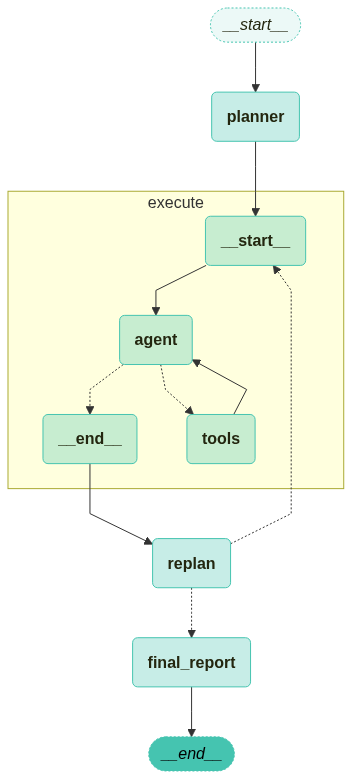

In [83]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)


In [84]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

inputs = {
    "input": "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점을 설명해줘"
}

invoke_graph(app, inputs, config)



🔄 Node: planner 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Naive RAG의 구조와 동작 방식을 설명한다.
Modular RAG의 구조와 동작 방식을 설명한다.
Naive RAG와 Modular RAG의 구조적 차이점을 비교한다.
Production level에서 Modular RAG를 사용할 때의 이점을 정리한다.
각 이점이 실제 서비스 운영에 어떻게 도움이 되는지 설명한다.

🔄 Node: agent in [execute] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Naive RAG(naive Retrieval-Augmented Generation)의 구조와 동작 방식

Naive RAG는 정보 검색(Retrieval)과 생성(Generation)을 결합한 자연어 처리(NLP) 프레임워크의 가장 기본적인 형태입니다. 주로 대형 언어 모델(LLM)과 외부 지식 베이스(문서, 데이터베이스 등)를 함께 활용하여, 입력 질문에 대해 더 정확하고 풍부한 답변을 생성하는 데 사용됩니다.

구조

- Query 입력: 사용자가 질문(질의, Query)을 입력합니다.
- Retriever(검색기): 입력된 질문을 바탕으로 외부 지식 베이스에서 관련성이 높은 문서나 정보를 검색합니다.
- Generator(생성기): 검색된 문서와 원래 질문을 함께 받아, 대형 언어 모델(예: GPT, BERT 등)이 최종 답변을 생성합니다.

동작 방식

- 사용자가 질문을 입력합니다.
- Retriever가 질문과 유사한 문서(또는 문서의 일부)를 외부 지식 베이스에서 찾아냅니다.
- Generator가 검색된 문서와 질문을 함께 입력받아, 이를 바탕으로 자연어로 답변을 생성합니다.
- 생성된 답변을 사용자에게 제공합니다.


In [85]:
snapshot = app.get_state(config).values
print(snapshot["response"])


# Modular RAG와 Naive RAG의 구조적 차이 및 Production 환경에서의 이점

## 1. 서론

Retrieval-Augmented Generation(RAG)은 대형 언어 모델(LLM)에 외부 지식 베이스의 정보를 결합하여, 보다 정확하고 풍부한 답변을 생성하는 대표적인 자연어 처리 프레임워크입니다. 최근에는 단순한 Naive RAG 구조를 넘어, 각 기능별로 모듈화된 Modular RAG가 주목받고 있습니다. 본 보고서에서는 Naive RAG와 Modular RAG의 구조적 차이와, Modular RAG가 실제 서비스(Production level) 환경에서 제공하는 주요 이점에 대해 정리합니다.

---

## 2. Naive RAG의 구조와 동작 방식

Naive RAG는 다음과 같은 단순한 파이프라인 구조를 가집니다.

- **Query 입력**: 사용자가 질문을 입력
- **Retriever(검색기)**: 외부 지식 베이스에서 관련 문서 검색
- **Generator(생성기)**: 검색된 문서와 질문을 함께 받아 LLM이 답변 생성

이 방식은 검색과 생성이 순차적으로 한 번에 이루어지며, 별도의 전처리나 후처리 과정이 거의 없습니다. 구조가 단순하여 구현이 쉽지만, 각 단계가 밀접하게 결합되어 있어 유연성과 확장성이 제한적입니다.

---

## 3. Modular RAG의 구조와 동작 방식

Modular RAG는 전체 파이프라인을 여러 개의 독립적인 모듈로 분리하여 구성합니다. 주요 모듈은 다음과 같습니다.

- **데이터 전처리 모듈**: 원본 데이터 정제 및 분할, 임베딩 생성 준비
- **인덱싱 모듈**: 전처리된 데이터를 벡터DB 등에 저장, 인덱스 구축
- **검색(Retrieval) 모듈**: 쿼리와 유사한 문서 검색
- **생성(Generation) 모듈**: 검색된 문서를 바탕으로 LLM이 답변 생성
- **후처리 및 평가 모듈**: 생성된 답변의 정제 및 품질 평가

각 모듈은 독립적으로 동작하며, 필요에 

In [86]:
from IPython.display import Markdown

Markdown(snapshot["response"])


# Modular RAG와 Naive RAG의 구조적 차이 및 Production 환경에서의 이점

## 1. 서론

Retrieval-Augmented Generation(RAG)은 대형 언어 모델(LLM)에 외부 지식 베이스의 정보를 결합하여, 보다 정확하고 풍부한 답변을 생성하는 대표적인 자연어 처리 프레임워크입니다. 최근에는 단순한 Naive RAG 구조를 넘어, 각 기능별로 모듈화된 Modular RAG가 주목받고 있습니다. 본 보고서에서는 Naive RAG와 Modular RAG의 구조적 차이와, Modular RAG가 실제 서비스(Production level) 환경에서 제공하는 주요 이점에 대해 정리합니다.

---

## 2. Naive RAG의 구조와 동작 방식

Naive RAG는 다음과 같은 단순한 파이프라인 구조를 가집니다.

- **Query 입력**: 사용자가 질문을 입력
- **Retriever(검색기)**: 외부 지식 베이스에서 관련 문서 검색
- **Generator(생성기)**: 검색된 문서와 질문을 함께 받아 LLM이 답변 생성

이 방식은 검색과 생성이 순차적으로 한 번에 이루어지며, 별도의 전처리나 후처리 과정이 거의 없습니다. 구조가 단순하여 구현이 쉽지만, 각 단계가 밀접하게 결합되어 있어 유연성과 확장성이 제한적입니다.

---

## 3. Modular RAG의 구조와 동작 방식

Modular RAG는 전체 파이프라인을 여러 개의 독립적인 모듈로 분리하여 구성합니다. 주요 모듈은 다음과 같습니다.

- **데이터 전처리 모듈**: 원본 데이터 정제 및 분할, 임베딩 생성 준비
- **인덱싱 모듈**: 전처리된 데이터를 벡터DB 등에 저장, 인덱스 구축
- **검색(Retrieval) 모듈**: 쿼리와 유사한 문서 검색
- **생성(Generation) 모듈**: 검색된 문서를 바탕으로 LLM이 답변 생성
- **후처리 및 평가 모듈**: 생성된 답변의 정제 및 품질 평가

각 모듈은 독립적으로 동작하며, 필요에 따라 교체·확장·튜닝이 가능합니다.

---

## 4. Naive RAG와 Modular RAG의 구조적 차이

| 구분         | Naive RAG                | Modular RAG                        |
|--------------|--------------------------|-------------------------------------|
| 구조         | 단일 파이프라인          | 모듈화된 파이프라인                 |
| 컴포넌트     | 검색기 + 생성기          | 검색기, 필터, 랭커, 생성기 등       |
| 유연성       | 낮음                     | 높음                                |
| 확장성       | 제한적                   | 높음                                |
| 운영 난이도  | 낮음(단순)               | 높음(복잡)                          |

- **Naive RAG**는 단순한 구조로 빠른 구현이 가능하지만, 각 단계의 독립적 개선이나 확장이 어렵습니다.
- **Modular RAG**는 각 기능이 모듈화되어 있어, 서비스 요구에 따라 손쉽게 구조를 변경하거나 확장할 수 있습니다.

---

## 5. Production 환경에서 Modular RAG의 이점

Modular RAG는 실제 서비스 환경에서 다음과 같은 장점을 제공합니다.

1. **유연한 아키텍처 구성**
   - 다양한 데이터 소스, 벡터DB, 검색 엔진, LLM 등을 모듈 단위로 교체·확장 가능
   - 서비스 요구사항 변화에 빠르게 대응

2. **유지보수 및 확장성 용이**
   - 각 모듈이 독립적으로 동작하여, 특정 기능만 별도 개선·확장 가능
   - 장애 발생 시 문제 모듈만 교체/수정 가능, 전체 서비스 안정성 향상

3. **성능 최적화**
   - 각 단계별로 최적화된 솔루션 적용 가능
   - 병렬 처리, 캐싱 등 성능 개선 전략을 모듈 단위로 적용

4. **테스트 및 검증 용이**
   - 각 모듈별 단위 테스트 가능, 시스템 신뢰성 향상
   - 새로운 기술이나 모델을 부분적으로 적용해 실험 가능

5. **보안 및 접근 제어 강화**
   - 민감 데이터 접근, 인증, 로깅 등 보안 기능을 별도 모듈로 관리

6. **비용 효율성**
   - 필요에 따라 특정 모듈만 클라우드 리소스를 확장/축소하여 비용 효율적 운영 가능

---

## 6. 결론

Modular RAG는 Naive RAG에 비해 구조적 유연성과 확장성이 뛰어나며, 실제 서비스 환경에서의 운영 효율성, 성능 최적화, 보안 강화 등 다양한 이점을 제공합니다. 복잡한 요구사항과 빠른 변화에 대응해야 하는 Production 환경에서는 Modular RAG의 도입이 점차 필수적인 선택이 되고 있습니다.

06. 멀티 에이전트 협업 네트워크(Multi-Agent Collaboration Network)

In [100]:
from langchain_teddynote.models import get_model_name, LLMs

# 최신 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4o)

print(MODEL_NAME)


gpt-4o


In [101]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage


# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  # Agent 간 공유하는 메시지 목록
    sender: Annotated[str, "The sender of the last message"]  # 마지막 메시지의 발신자


In [102]:
from typing import Annotated

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 검색 도구 정의
tavily_tool = TavilySearch(max_results=5)

# Python 코드를 실행하는 도구 정의
python_repl = PythonREPL()


# Python 코드를 실행하는 도구 정의
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # 주어진 코드를 Python REPL에서 실행하고 결과 반환
        result = python_repl.run(code)
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"
    # 실행 성공 시 결과와 함께 성공 메시지 반환
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


In [103]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )


In [104]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState

# LLM 정의
llm = ChatOpenAI(model=MODEL_NAME)

# Research Agent 생성
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


# Research Agent 노드 정의
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        # Research Agent 의 메시지 목록 반환
        "messages": [last_message],
    }


In [105]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""

# Chart Generator Agent 생성
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(chart_generator_system_prompt),
)


In [106]:
def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        # share internal message history of chart agent with other agents
        "messages": [last_message],
    }


In [107]:
from langgraph.graph import END


def router(state: MessagesState):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"


In [108]:
from langchain_core.messages import HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
app = workflow.compile(checkpointer=MemorySaver())


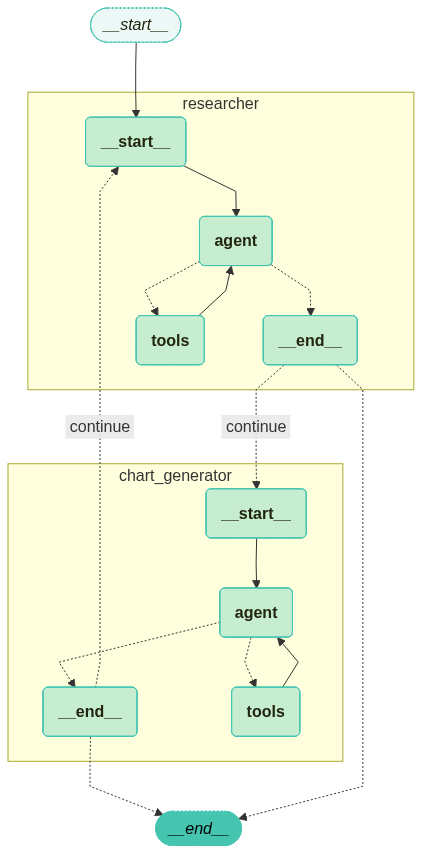

In [109]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)


In [110]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])



🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_SFrMJLeGNgPNZ9QAt5iV8Glm)
 Call ID: call_SFrMJLeGNgPNZ9QAt5iV8Glm
  Args:
    query: 대한민국 2010 to 2023 1인당 GDP 데이터
  tavily_web_search (call_FSptEZU8QUx2cOao9RynICRy)
 Call ID: call_FSptEZU8QUx2cOao9RynICRy
  Args:
    query: 대한민국 2024 예측 1인당 GDP


RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4o in organization org-Soffyuxth7vsUnobnzk0MGeR on tokens per min (TPM): Limit 30000, Requested 68416. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

07. 멀티 에이전트 감독자(Multi-Agent Supervisor)

In [144]:
from langchain_teddynote.models import get_model_name, LLMs

# 최신 버전의 모델명을 가져옵니다.
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)


gpt-4o


In [145]:
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage


# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # 메시지
    next: str  # 다음으로 라우팅할 에이전트


In [146]:
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_experimental.tools import PythonREPLTool

# 최대 5개의 검색 결과를 반환하는 Tavily 검색 도구 초기화
tavily_tool = TavilySearch(max_results=5)

# 로컬에서 코드를 실행하는 Python REPL 도구 초기화 (안전하지 않을 수 있음)
python_repl_tool = PythonREPLTool()


In [147]:
from langchain_core.messages import HumanMessage


# 지정한 agent와 name을 사용하여 agent 노드를 생성
def agent_node(state, agent, name):
    # agent 호출
    agent_response = agent.invoke(state)
    # agent의 마지막 메시지를 HumanMessage로 변환하여 반환
    return {
        "messages": [
            HumanMessage(content=agent_response["messages"][-1].content, name=name)
        ]
    }


In [148]:
import functools
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI


# Research Agent 생성
research_agent = create_react_agent(ChatOpenAI(model=MODEL_NAME), tools=[tavily_tool])

# research node 생성
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


In [149]:
research_node(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
)


{'messages': [HumanMessage(content='Here\'s a simple code snippet in Python to print "Hello, World!" to the terminal:\n\n```python\nprint("Hello, World!")\n```\n\nYou can run this code in any Python environment or terminal to see the output. If you need a similar example in another programming language, feel free to ask!', additional_kwargs={}, response_metadata={}, name='Researcher')]}

In [150]:
from pydantic import BaseModel
from typing import Literal

# 멤버 Agent 목록 정의
members = ["Researcher", "Coder"]

# 다음 작업자 선택 옵션 목록 정의
options_for_next = ["FINISH"] + members


# 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
class RouteResponse(BaseModel):
    next: Literal[options_for_next]


In [157]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


# 시스템 프롬프트 정의: 작업자 간의 대화를 관리하는 감독자 역할
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# ChatPromptTemplate 생성
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options_for_next), members=", ".join(members))


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)


# Supervisor Agent 생성
def supervisor_agent(state):
    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    
    # 여기서 응답을 직접 호출하고 출력합니다.
    response = supervisor_chain.invoke(state)
    
    # 디버깅을 위해 응답 값 출력
    print("\n--- LLM 응답 값 ---")
    print(response)
    print("-------------------\n")
    
    # Agent 호출
    return response


In [158]:
import functools
from langgraph.prebuilt import create_react_agent


# Research Agent 생성
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_system_prompt = """
Be sure to use the following font in your code for visualization.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""


# Coder Agent 생성
coder_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=code_system_prompt,
)
coder_node = functools.partial(agent_node, agent=coder_agent, name="Coder")


In [159]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(AgentState)

# 그래프에 노드 추가
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("Supervisor", supervisor_agent)


# 멤버 노드 > Supervisor 노드로 엣지 추가
for member in members:
    workflow.add_edge(member, "Supervisor")

# 조건부 엣지 추가 (
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END


def get_next(state):
    return state["next"]


# Supervisor 노드에서 조건부 엣지 추가
workflow.add_conditional_edges("Supervisor", get_next, conditional_map)

# 시작점
workflow.add_edge(START, "Supervisor")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())


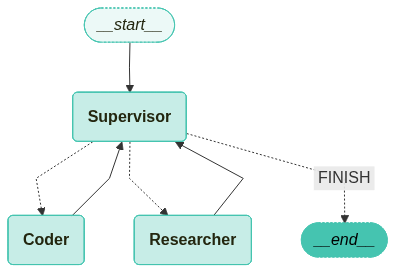

In [160]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)


In [161]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(graph, inputs, config)


/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:425: UserWarning: Invalid schema for OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. Specify `method="function_calling"` instead or update your schema. See supported schemas: https://platform.openai.com/docs/guides/structured-outputs#supported-schemas
  warnings.warn(message)


BadRequestError: Error code: 400 - {'error': {'message': "Invalid schema for response_format 'RouteResponse': In context=('properties', 'next'), array schema missing items.", 'type': 'invalid_request_error', 'param': 'response_format', 'code': None}}

08. 계층적 멀티 에이전트 팀(Hierarchical Multi-Agent Teams)

In [162]:
from langchain_teddynote.models import get_model_name, LLMs

# 최신 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)


gpt-4o


In [163]:
from typing import List
from langchain_community.document_loaders import WebBaseLoader
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.tools import tool

# 검색 도구 정의(TavilySearch)
tavily_tool = TavilySearch(max_results=5)


# 웹 페이지에서 세부 정보를 스크래핑하기 위한 도구 정의
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    # 주어진 URL 목록을 사용하여 웹 페이지 로드
    loader = WebBaseLoader(
        web_path=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
        },
    )
    docs = loader.load()

    # 로드된 문서의 제목과 내용을 포함한 문자열 생성
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [164]:
from pathlib import Path
from typing import Dict, Optional, List
from typing_extensions import Annotated


# 임시 디렉토리 생성 및 작업 디렉토리 설정
WORKING_DIRECTORY = Path("./tmp")

# tmp 폴더가 없으면 생성
WORKING_DIRECTORY.mkdir(exist_ok=True)


# 아웃라인 생성 및 파일로 저장
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    # 주어진 파일 이름으로 아웃라인을 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# 문서 읽기
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    # 시작 줄이 지정되지 않은 경우 기본값 설정
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# 문서 쓰기 및 저장
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    # 주어진 파일 이름으로 문서 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# 문서 편집
@tool
def edit_document(
    file_name: Annotated[str, "File path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "File path of the edited document."]:
    """Edit a document by inserting text at specific line numbers."""

    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    # 삽입할 텍스트를 정렬하여 처리
    sorted_inserts = sorted(inserts.items())

    # 지정된 줄 번호에 텍스트 삽입
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    # 편집된 문서를 파일에 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


In [165]:
from langchain_experimental.tools import PythonREPLTool

# PythonREPL 도구
python_repl_tool = PythonREPLTool()


In [166]:
from langgraph.graph import START, END
from langchain_core.messages import HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 에이전트 팩토리 클래스
class AgentFactory:
    def __init__(self, model_name):
        self.llm = ChatOpenAI(model=model_name, temperature=0)

    def create_agent_node(self, agent, name: str):
        # 노드 생성 함수
        def agent_node(state):
            result = agent.invoke(state)
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ]
            }

        return agent_node


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Agent Factory 인스턴스 생성
agent_factory = AgentFactory(MODEL_NAME)


In [167]:
# 에이전트 정의
search_agent = create_react_agent(llm, tools=[tavily_tool])
# 에이전트 노드 생성
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")


In [169]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal


def create_team_supervisor(model_name, system_prompt, members) -> str:
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next = ["FINISH"] + members

    # 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
    class RouteResponse(BaseModel):
        next: Literal[options_for_next]

    # ChatPromptTemplate 생성
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options_for_next))

    # LLM 초기화
    llm = ChatOpenAI(model=model_name, temperature=0)

    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain


In [170]:
import operator
from typing import List, TypedDict
from typing_extensions import Annotated

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 상태 정의
class ResearchState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]  # 메시지
    team_members: List[str]  # 멤버 에이전트 목록
    next: str  # Supervisor 에이전트에게 다음 작업자를 선택하도록 지시


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 검색 노드 생성
search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

# 웹 스크래핑 노드 생성
web_scraping_agent = create_react_agent(llm, tools=[scrape_webpages])
web_scraping_node = agent_factory.create_agent_node(
    web_scraping_agent, name="WebScraper"
)

# Supervisor 에이전트 생성
supervisor_agent = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)


In [171]:
def get_next_node(x):
    return x["next"]


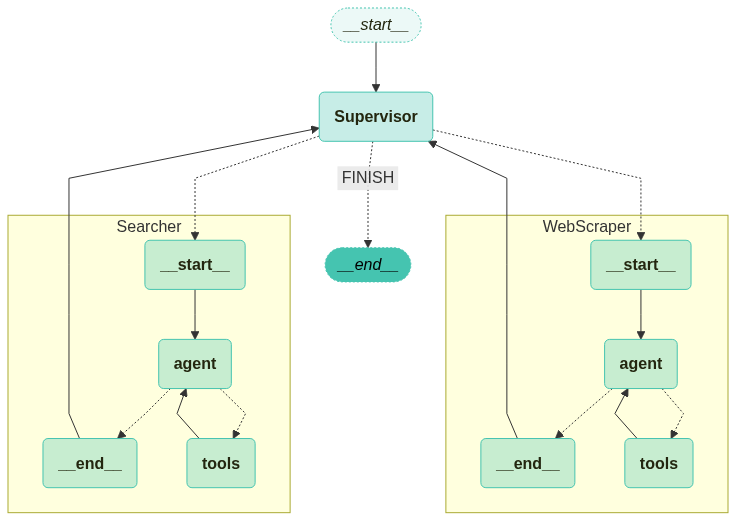

In [172]:
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
web_research_graph = StateGraph(ResearchState)

# 노드 추가
web_research_graph.add_node("Searcher", search_node)
web_research_graph.add_node("WebScraper", web_scraping_node)
web_research_graph.add_node("Supervisor", supervisor_agent)

# 엣지 추가
web_research_graph.add_edge("Searcher", "Supervisor")
web_research_graph.add_edge("WebScraper", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
web_research_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {"Searcher": "Searcher", "WebScraper": "WebScraper", "FINISH": END},
)

# 시작 노드 설정
web_research_graph.set_entry_point("Supervisor")

# 그래프 컴파일
web_research_app = web_research_graph.compile(checkpointer=MemorySaver())

# 그래프 시각화
visualize_graph(web_research_app, xray=True)


In [173]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph


def run_graph(app, message: str, recursive_limit: int = 50):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    # 그래프 실행
    invoke_graph(app, inputs, config)

    return app.get_state(config).values


In [174]:
output = run_graph(
    web_research_app,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)


/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:425: UserWarning: Invalid schema for OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. Specify `method="function_calling"` instead or update your schema. See supported schemas: https://platform.openai.com/docs/guides/structured-outputs#supported-schemas
  warnings.warn(message)


BadRequestError: Error code: 400 - {'error': {'message': "Invalid schema for response_format 'RouteResponse': In context=('properties', 'next'), array schema missing items.", 'type': 'invalid_request_error', 'param': 'response_format', 'code': None}}

In [ ]:
# 최종 결과 출력
print(output["messages"][-1].content)


09. SQL 데이터베이스와 상호작용하는 에이전트


In [175]:
from langchain_teddynote.models import get_model_name, LLMs

MODEL_NAME = get_model_name(LLMs.GPT4o)
print(f"사용하는 모델명: {MODEL_NAME}")


사용하는 모델명: gpt-4o


In [176]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    with open("Chinook.db", "wb") as file:
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


File downloaded and saved as Chinook.db


In [177]:
from langchain_community.utilities import SQLDatabase

# SQLite 데이터베이스 파일에서 SQLDatabase 인스턴스 생성
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# DB dialect 출력(sqlite)
print(db.dialect)

# 데이터베이스에서 사용 가능한 테이블 이름 목록 출력
print(db.get_usable_table_names())

# SQL 쿼리 실행
db.run("SELECT * FROM Artist LIMIT 5;")


sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]"

In [178]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


# 오류 처리 함수
def handle_tool_error(state) -> dict:
    # 오류 정보 조회
    error = state.get("error")
    # 도구 정보 조회
    tool_calls = state["messages"][-1].tool_calls
    # ToolMessage 로 래핑 후 반환
    return {
        "messages": [
            ToolMessage(
                content=f"Here is the error: {repr(error)}\n\nPlease fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


# 오류를 처리하고 에이전트에 오류를 전달하기 위한 ToolNode 생성
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    # 오류 발생 시 대체 동작을 정의하여 ToolNode에 추가
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


In [179]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

# SQLDatabaseToolkit 생성
toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model=MODEL_NAME))

# SQLDatabaseToolkit에서 사용 가능한 도구 목록
tools = toolkit.get_tools()
tools


[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1391cb3a0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1391cb3a0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1391cb3a0>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

In [180]:
# 데이터베이스에서 사용 가능한 테이블을 나열하는 도구 선택
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

# 특정 테이블의 DDL을 가져오는 도구 선택
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# 데이터베이스의 모든 테이블 목록 출력
print(list_tables_tool.invoke(""))

# Artist 테이블의 DDL 정보 출력
print(get_schema_tool.invoke("Artist"))


Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [181]:
from langchain_core.tools import tool


# Query 실행 도구
@tool
def db_query_tool(query: str) -> str:
    """
    Run SQL queries against a database and return results
    Returns an error message if the query is incorrect
    If an error is returned, rewrite the query, check, and retry
    """
    # 쿼리 실행
    result = db.run_no_throw(query)

    # 오류: 결과가 없으면 오류 메시지 반환
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    # 정상: 쿼리 실행 결과 반환
    return result


In [182]:
# Artist 테이블에서 상위 10개 행 선택 및 실행 결과 출력
print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))


[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [183]:
# Artist 테이블에서 상위 10개 행 선택 및 실행 결과 출력
print(db_query_tool.invoke("SELECT * FROM Artist LIMITS 10;"))


Error: (sqlite3.OperationalError) near "10": syntax error
[SQL: SELECT * FROM Artist LIMITS 10;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [184]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# SQL 쿼리의 일반적인 실수를 점검하기 위한 시스템 메시지 정의
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# 프롬프트 생성
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)

# Query Checker 체인 생성
query_check = query_check_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).bind_tools([db_query_tool], tool_choice="db_query_tool")


In [185]:
# 사용자 메시지를 사용하여 쿼리 점검 노드 실행
response = query_check.invoke(
    {"messages": [("user", "SELECT * FROM Artist LIMITS 10;")]}
)
print(response.tool_calls[0])


{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10;'}, 'id': 'call_Gde0XQ7hxjfhTVkpNi9VMW1t', 'type': 'tool_call'}


In [186]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver


# 에이전트의 상태 정의
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# 새로운 그래프 정의
workflow = StateGraph(State)


# 첫 번째 도구 호출을 위한 노드 추가
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "initial_tool_call_abc123",
                    }
                ],
            )
        ]
    }


# 쿼리의 정확성을 모델로 점검하기 위한 함수 정의
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to check that your query is correct before you run it
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


# 첫 번째 도구 호출 노드 추가
workflow.add_node("first_tool_call", first_tool_call)

# 첫 번째 두 도구를 위한 노드 추가
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# 질문과 사용 가능한 테이블을 기반으로 관련 테이블을 선택하는 모델 노드 추가
model_get_schema = ChatOpenAI(model=MODEL_NAME, temperature=0).bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# 최종 상태를 나타내는 도구 설명
class SubmitFinalAnswer(BaseModel):
    """쿼리 결과를 기반으로 사용자에게 최종 답변 제출"""

    final_answer: str = Field(..., description="The final answer to the user")


# 질문과 스키마를 기반으로 쿼리를 생성하기 위한 모델 노드 추가
QUERY_GEN_INSTRUCTION = """You are a SQL expert with a strong attention to detail.

You can define SQL queries, analyze queries results and interpretate query results to response an answer.

Read the messages bellow and identify the user question, table schemas, query statement and query result, or error if they exist.

1. If there's not any query result that make sense to answer the question, create a syntactically correct SQLite query to answer the user question. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

2. If you create a query, response ONLY the query statement. For example, "SELECT id, name FROM pets;"

3. If a query was already executed, but there was an error. Response with the same error message you found. For example: "Error: Pets table doesn't exist"

4. If a query was already executed successfully interpretate the response and answer the question following this pattern: Answer: <<question answer>>. For example: "Answer: There three cats registered as adopted"
"""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", QUERY_GEN_INSTRUCTION), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | ChatOpenAI(model=MODEL_NAME, temperature=0).bind_tools(
    [SubmitFinalAnswer, model_check_query]
)


# 조건부 에지 정의
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]

    last_message = messages[-1]
    if last_message.content.startswith("Answer:"):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# 쿼리 생성 노드 정의
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # LLM이 잘못된 도구를 호출할 경우 오류 메시지를 반환
    tool_messages = []
    message.pretty_print()
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


# 쿼리 생성 노드 추가
workflow.add_node("query_gen", query_gen_node)

# 쿼리를 실행하기 전에 모델로 점검하는 노드 추가
workflow.add_node("correct_query", model_check_query)

# 쿼리를 실행하기 위한 노드 추가
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# 노드 간의 엣지 지정
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# 실행 가능한 워크플로우로 컴파일
app = workflow.compile(checkpointer=MemorySaver())


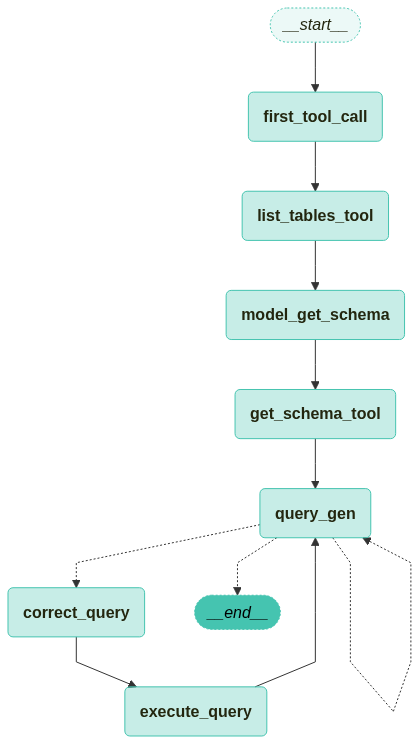

In [187]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)


In [188]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph, stream_graph
from langchain_core.messages import HumanMessage
from langgraph.errors import GraphRecursionError


def run_graph(
    message: str, recursive_limit: int = 30, node_names=[], stream: bool = False
):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    try:
        if stream:
            # 그래프 실행
            stream_graph(app, inputs, config, node_names=node_names)
        else:
            invoke_graph(app, inputs, config, node_names=node_names)
        output = app.get_state(config).values
        return output
    except GraphRecursionError as recursion_error:
        print(f"GraphRecursionError: {recursion_error}")
        output = app.get_state(config).values
        return output


In [189]:
output = run_graph(
    "Andrew Adam 직원의 인적정보를 모두 조회해줘",
    stream=False,
)



🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (initial_tool_call_abc123)
 Call ID: initial_tool_call_abc123
  Args:

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_O3yTy4KRztcnxRsE6gPpuX7Y)
 Call ID: call_O3yTy4KRztcnxRsE6gPpuX7Y
  Args:
    table_names: Employee

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message ===========================

In [190]:
output = run_graph(
    "2009년도에 어느 국가의 고객이 가장 많이 지출했을까요? 그리고 얼마를 지출했을까요? 한글로 답변하세요.",
    stream=False,
)



🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (initial_tool_call_abc123)
 Call ID: initial_tool_call_abc123
  Args:

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_JMeyAhbiQQ6Hi8GhO56ir2Ds)
 Call ID: call_JMeyAhbiQQ6Hi8GhO56ir2Ds
  Args:
    table_names: Customer, Invoice

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message ==================

In [191]:
from langsmith import Client

# 클라이언트 초기화
client = Client()

# 데이터셋 생성 및 업로드
examples = [
    (
        "Which country's customers spent the most? And how much did they spend?",
        "The country whose customers spent the most is the USA, with a total spending of 523.06.",
    ),
    (
        "What was the most purchased track of 2013?",
        "The most purchased track of 2013 was Hot Girl.",
    ),
    (
        "How many albums does the artist Led Zeppelin have?",
        "Led Zeppelin has 14 albums",
    ),
    (
        "What is the total price for the album “Big Ones”?",
        "The total price for the album 'Big Ones' is 14.85",
    ),
    (
        "Which sales agent made the most in sales in 2009?",
        "Steve Johnson made the most sales in 2009",
    ),
]

dataset_name = "SQL Agent Response"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)


In [192]:
# 에이전트의 SQL 쿼리 응답을 예측하기 위한 함수 정의
def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    config = RunnableConfig(configurable={"thread_id": random_uuid()})

    inputs = {
        "messages": [HumanMessage(content=example["input"])],
    }
    # 그래프를 실행하여 메시지 결과 조회
    messages = app.invoke(inputs, config)
    answer = messages["messages"][-1].content
    # 결과 반환
    return {"response": answer}


In [193]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


# 답변 평가자 LLM-as-judge 정의
def answer_evaluator(run, example) -> dict:
    # input: 질문
    input_question = example.inputs["input"]
    # output: 참조 답변
    reference = example.outputs["output"]
    # 예측 답변
    prediction = run.outputs["response"]

    # LLM 평가자 초기화
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # 평가자 실행
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]

    # 점수 반환
    return {"key": "answer_v_reference_score", "score": score}


In [194]:
from langsmith.evaluation import evaluate

# 평가용 데이터셋 이름
dataset_name = "SQL Agent Response"

try:
    # 평가 진행
    experiment_results = evaluate(
        predict_sql_agent_answer,  # 평가시 활용할 예측 함수
        data=dataset_name,  # 평가용 데이터셋 이름
        evaluators=[answer_evaluator],  # 평가자 목록
        num_repetitions=3,  # 실험 반복 횟수 설정
        experiment_prefix="sql-agent-eval",
        metadata={"version": "chinook db, sql-agent-eval: gpt-4o"},  # 실험 메타데이터
    )
except Exception as e:
    print(e)


View the evaluation results for experiment: 'sql-agent-eval-b55dacd7' at:
https://smith.langchain.com/o/53db61eb-d386-4c02-9de8-5b28476b0edc/datasets/4c01e9c9-dfee-427a-8251-cebd69bbc095/compare?selectedSessions=f1513783-462d-43a7-8642-be3dfb0a3e9b




0it [00:00, ?it/s]

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_BVj9xlvpkd5bAp6j6YFo1ZOF)
 Call ID: call_BVj9xlvpkd5bAp6j6YFo1ZOF
  Args:
    state: {'messages': [{'content': 'What was the most purchased track of 2013?', 'type': 'human'}, {'content': 'CREATE TABLE "Invoice" (\n\t"InvoiceId" INTEGER NOT NULL, \n\t"CustomerId" INTEGER NOT NULL, \n\t"InvoiceDate" DATETIME NOT NULL, \n\t"BillingAddress" NVARCHAR(70), \n\t"BillingCity" NVARCHAR(40), \n\t"BillingState" NVARCHAR(40), \n\t"BillingCountry" NVARCHAR(40), \n\t"BillingPostalCode" NVARCHAR(10), \n\t"Total" NUMERIC(10, 2) NOT NULL, \n\tPRIMARY KEY ("InvoiceId"), \n\tFOREIGN KEY("CustomerId") REFERENCES "Customer" ("CustomerId")\n)\n\n/*\n3 rows from Invoice table:\nInvoiceId\tCustomerId\tInvoiceDate\tBillingAddress\tBillingCity\tBillingState\tBillingCountry\tBillingPostalCode\tTotal\n1\t2\t2009-01-01 00:00:00\tTheodor-Heuss-Straße 34\tStuttgart\tNone\tGermany\t70174\t1.98\n2\t4\

Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-Soffyuxth7vsUnobnzk0MGeR on tokens per min (TPM): Limit 30000, Used 28954, Requested 1073. Please try again in 54ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langsmith/evaluation/_runner.py", line 1924, in _forward
    fn(*args, langsmith_extra=langsmith_extra)
  File "/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langsmith/run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "/var/folders/sj/3r49bs6178v7nfhcxh7lpzd80000gn/T/ipykernel_43129/2799409917.py", line 10, in predict_sql_agent_answer
    messages = app.invoke(inputs, config)
  File "/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langgraph/pregel/

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_OHFP0VpCv4485aDnVHL91kiS)
 Call ID: call_OHFP0VpCv4485aDnVHL91kiS
  Args:
    state: {'messages': [{'content': 'What is the total price for the album “Big Ones”?', 'type': 'human'}, {'content': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', 'type': 'function', 'name': 'sql_db_list_tables'}, {'content': 'CREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/', 'type': 'function', 'name': 'sql_db_schema'}, {'content': 'CREATE TABLE "InvoiceLine" (\n\t"InvoiceLineId" INTEGER NOT NULL, \n\t"InvoiceId

Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-Soffyuxth7vsUnobnzk0MGeR on tokens per min (TPM): Limit 30000, Used 30000, Requested 706. Please try again in 1.412s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langsmith/evaluation/_runner.py", line 1924, in _forward
    fn(*args, langsmith_extra=langsmith_extra)
  File "/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langsmith/run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "/var/folders/sj/3r49bs6178v7nfhcxh7lpzd80000gn/T/ipykernel_43129/2799409917.py", line 10, in predict_sql_agent_answer
    messages = app.invoke(inputs, config)
  File "/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langgraph/pregel

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_YrcMwHj4LaZWfUQiTPvf9jOI)
 Call ID: call_YrcMwHj4LaZWfUQiTPvf9jOI
  Args:
    state: {'messages': [{'content': 'Which sales agent made the most in sales in 2009?', 'type': 'human'}, {'content': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', 'type': 'function', 'name': 'sql_db_list_tables', 'id': 'b1b0b3b3-0b0b-4b0b-9b0b-0b0b0b0b0b0b'}, {'content': 'parallel', 'type': 'tool_use', 'tool_calls': [{'name': 'functions.sql_db_schema', 'args': '{"table_names":"Employee"}', 'id': 'b1b0b3b3-0b0b-4b0b-9b0b-0b0b0b0b0b0b'}, {'name': 'functions.sql_db_schema', 'args': '{"table_names":"Invoice"}', 'id': 'b1b0b3b3-0b0b-4b0b-9b0b-0b0b0b0b0b0b'}], 'id': 'b1b0b3b3-0b0b-4b0b-9b0b-0b0b0b0b0b0b'}, {'content': '\nCREATE TABLE "Employee" (\n\t"EmployeeId" INTEGER NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"FirstName" NVAR

Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-Soffyuxth7vsUnobnzk0MGeR on tokens per min (TPM): Limit 30000, Used 30000, Requested 229. Please try again in 458ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langsmith/evaluation/_runner.py", line 1924, in _forward
    fn(*args, langsmith_extra=langsmith_extra)
  File "/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langsmith/run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "/var/folders/sj/3r49bs6178v7nfhcxh7lpzd80000gn/T/ipykernel_43129/2799409917.py", line 10, in predict_sql_agent_answer
    messages = app.invoke(inputs, config)
  File "/opt/anaconda3/envs/LangGraph/lib/python3.10/site-packages/langgraph/pregel/

10. STORM 개념을 도입한 연구를 위한 멀티 에이전트

In [195]:
from langchain_teddynote.models import get_model_name, LLMs
from langchain_openai import ChatOpenAI

# 최신 모델 가져오기
GPT4o = get_model_name(LLMs.GPT4o)

# 모델 초기화
llm = ChatOpenAI(model=GPT4o)


In [196]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_teddynote.graphs import visualize_graph


# 분석가의 속성과 메타데이터를 정의하는 클래스
class Analyst(BaseModel):
    # 주요 소속 정보
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    # 이름
    name: str = Field(description="Name of the analyst.")

    # 역할
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    # 중점, 우려 사항 및 동기에 대한 설명
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    # 분석가의 인적 정보를 문자열로 반환하는 속성
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


# 분석가들의 집합
class Perspectives(BaseModel):
    # 분석가 목록
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )


In [197]:
# 상태 정의
class GenerateAnalystsState(TypedDict):
    # 연구 주제
    topic: str
    # 생성할 분석가의 최대 수
    max_analysts: int
    # 사람 피드백
    human_analyst_feedback: str
    # 분석가 목록
    analysts: List[Analyst]


In [198]:
from langgraph.graph import END
from langchain_core.messages import HumanMessage, SystemMessage

# 분석가 생성 프롬프트
analyst_instructions = """You are tasked with creating a set of AI analyst personas. 

Follow these instructions carefully:
1. First, review the research topic:

{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


# 분석가 생성 노드
def create_analysts(state: GenerateAnalystsState):
    """분석가 페르소나를 생성하는 함수"""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # LLM에 구조화된 출력 형식을 적용
    structured_llm = llm.with_structured_output(Perspectives)

    # 분석가 생성을 위한 시스템 프롬프트 구성
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    # LLM을 호출하여 분석가 페르소나 생성
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    # 생성된 분석가 목록을 상태에 저장
    return {"analysts": analysts.analysts}


# 사용자 피드백 노드(상태 업데이트를 진행할 예정이므로, 내용은 비워 두어도 무방)
def human_feedback(state: GenerateAnalystsState):
    """사용자 피드백을 받기 위한 중단점 노드"""
    pass


# 인간 피드백 여부에 따라 워크플로우의 다음 단계를 결정하는 함수
def should_continue(state: GenerateAnalystsState):
    """워크플로우의 다음 단계를 결정하는 함수"""

    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"

    return END


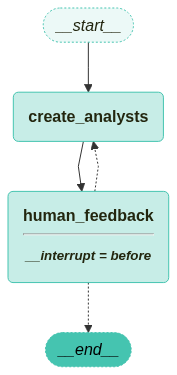

In [199]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage

# 그래프 생성
builder = StateGraph(GenerateAnalystsState)

# 노드 추가
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

# 엣지 연결
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")

# 조건부 엣지 추가: 사람 피드백이 있을 경우 다시 분석가 생성 노드로 돌아갑니다.
builder.add_conditional_edges(
    "human_feedback", should_continue, ["create_analysts", END]
)

# 메모리 생성
memory = MemorySaver()

# 그래프 컴파일(중단점 설정)
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# 그래프 시각화
visualize_graph(graph)


In [200]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": random_uuid()},
)

# 분석가 수 설정
max_analysts = 3

# 연구 주제 설정
topic = "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점"

# 입력 데이터 설정
inputs = {
    "topic": topic,
    "max_analysts": max_analysts,
}

# 그래프 실행
invoke_graph(graph, inputs, config)



🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='AI Research Lab' name='Dr. Emily Tan' role='AI Systems Researcher' description='Dr. Tan focuses on the architectural and performance improvements of AI models. Her major interest is in how Modular RAG can improve flexibility and scalability compared to Naive RAG, particularly in large-scale AI systems. She analyzes how the modular approach allows for more efficient resource management and adaptability in various production environments.'
affiliation='Tech Industry Observer' name='Michael Chen' role='Tech Industry Analyst' description="Michael observes trends and innovations in AI technologies as they apply to industry use. He studies the commercial advantages that Modular RAG offers over Naive RAG, such as ease of integration into existing workflows and the potential for cost reduction. Michael's interest lies in understanding how these features can lead to increased adoption in business settings

In [201]:
# 그래프의 현재 상태 가져오기
state = graph.get_state(config)

# 다음 실행할 노드 확인
print(state.next)


('human_feedback',)


In [202]:
# 그래프 상태를 업데이트하여 human_feedback 노드의 역할 수행
graph.update_state(
    config,
    {
        "human_analyst_feedback": "Add in someone named Teddy Lee from a startup to add an entrepreneur perspective"
    },
    as_node="human_feedback",
)


{'configurable': {'thread_id': '0f224407-101d-45c7-b3fc-89073ff26589',
  'checkpoint_ns': '',
  'checkpoint_id': '1f083d30-5f58-60cc-8002-d5d9fef4e090'}}

In [203]:
# 이어서 진행
invoke_graph(graph, None, config)



🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Independent Researcher' name='Dr. Hannah Kim' role='Academic Specialist' description='Dr. Kim is an academic researcher with a focus on machine learning frameworks and their applications in real-world scenarios. She is particularly interested in comparing Modular RAG and Naive RAG in terms of flexibility and efficiency for handling complex data requirements in production settings.'
affiliation='TechVision Analytics' name='Rahul Patel' role='Data Engineer' description='Rahul works as a data engineer who has extensive experience implementing and optimizing retrieval-augmented generation systems in various production environments. His interest lies in the practical aspects of how Modular RAG can enhance scalability and robustness compared to Naive RAG for enterprise-level applications.'
affiliation='Startup Founder' name='Teddy Lee' role='Entrepreneurial Thinker' description='Teddy is a co-founder o

In [204]:
# 추가 피드백이 없을 경우 None 값을 할당하여 상태 업데이트
human_feedback_input = None

# 그래프 상태를 업데이트하여 human_feedback 노드의 역할 수행
graph.update_state(
    config, {"human_analyst_feedback": human_feedback_input}, as_node="human_feedback"
)


{'configurable': {'thread_id': '0f224407-101d-45c7-b3fc-89073ff26589',
  'checkpoint_ns': '',
  'checkpoint_id': '1f083d30-e5ca-6b00-8004-7965721ba1e3'}}

In [205]:
# 이어서 진행
invoke_graph(graph, None, config)


In [206]:
# 그래프의 최종 상태 가져오기
final_state = graph.get_state(config)

# 최종 상태에서 생성된 분석가 목록 가져오기
analysts = final_state.values.get("analysts")

# 생성된 분석가 수 출력
print(f"생성된 분석가 수: {len(analysts)}", end="\n================================\n")

# 각 분석가의 페르소나 출력
for analyst in analysts:
    print(analyst.persona)
    print("- " * 30)


생성된 분석가 수: 3
Name: Dr. Hannah Kim
Role: Academic Specialist
Affiliation: Independent Researcher
Description: Dr. Kim is an academic researcher with a focus on machine learning frameworks and their applications in real-world scenarios. She is particularly interested in comparing Modular RAG and Naive RAG in terms of flexibility and efficiency for handling complex data requirements in production settings.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Name: Rahul Patel
Role: Data Engineer
Affiliation: TechVision Analytics
Description: Rahul works as a data engineer who has extensive experience implementing and optimizing retrieval-augmented generation systems in various production environments. His interest lies in the practical aspects of how Modular RAG can enhance scalability and robustness compared to Naive RAG for enterprise-level applications.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Name: Teddy Lee
Role: Entrepreneurial Thinker
Affiliation: Star

In [207]:
# 그래프의 다음 실행할 노드 상태 가져오기
print(final_state.next)


()


In [208]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState


# 인터뷰 상태 정의
class InterviewState(MessagesState):
    # 대화 턴수
    max_num_turns: int
    # 소스 문서를 포함하는 컨텍스트 리스트
    context: Annotated[list, operator.add]
    # 지정된 분석가
    analyst: Analyst
    # 인터뷰 내용을 저장하는 문자열
    interview: str
    # 보고서 섹션 리스트
    sections: list


# 검색 쿼리 데이터 클래스 정의
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")


In [209]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


# 질문을 생성하는 노드 정의
def generate_question(state: InterviewState):
    # 상태에서 분석가와 메시지 가져오기
    analyst = state["analyst"]
    messages = state["messages"]

    # 질문 생성
    # 분석가의 목표를 기반으로 시스템 메시지 생성
    system_message = question_instructions.format(goals=analyst.persona)
    # LLM을 사용하여 질문 생성
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # 상태에 메시지 기록
    return {"messages": [question]}


In [210]:
# 웹 검색 도구 초기화
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색을 위한 TavilySearch 인스턴스 생성
tavily_search = TavilySearch(max_results=3)


In [213]:
from langchain_community.retrievers import ArxivRetriever

# Arxiv 검색을 위한 ArxivRetriever 인스턴스 생성
arxiv_retriever = ArxivRetriever(
    load_max_docs=3,
    load_all_available_meta=True,
    get_full_documents=True,
)

# 검색 결과 출력
arxiv_search_results = arxiv_retriever.invoke("Modular RAG vs Naive RAG")
print(arxiv_search_results)


[Document(metadata={'Published': '2024-07-26', 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks', 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang', 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a high

In [214]:
# Arxiv 메타데이터 출력
arxiv_search_results[0].metadata


{'Published': '2024-07-26',
 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks',
 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang',
 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a highly reconfigurabl

In [215]:
# Arxiv 내용 출력
print(arxiv_search_results[0].page_content)


1
Modular RAG: Transforming RAG Systems into
LEGO-like Reconfigurable Frameworks
Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang
Abstract—Retrieval-augmented
Generation
(RAG)
has
markedly enhanced the capabilities of Large Language Models
(LLMs) in tackling knowledge-intensive tasks. The increasing
demands of application scenarios have driven the evolution
of RAG, leading to the integration of advanced retrievers,
LLMs and other complementary technologies, which in turn
has amplified the intricacy of RAG systems. However, the rapid
advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process
of “retrieve-then-generate”. In this context, this paper examines
the limitations of the existing RAG paradigm and introduces
the modular RAG framework. By decomposing complex RAG
systems into independent modules and specialized operators, it
facilitates a highly reconfigurable framework. Modular RAG
transcends the traditional linear architect

In [216]:
# 문서 검색 결과를 포맷팅
formatted_search_docs = "\n\n---\n\n".join(
    [
        f'<Document source="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
        for doc in arxiv_search_results
    ]
)


In [217]:
print(formatted_search_docs)


<Document source="http://arxiv.org/abs/2407.21059v1" date="2024-07-26" authors="Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang"/>
<Title>
Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks
</Title>

<Summary>
Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities
of Large Language Models (LLMs) in tackling knowledge-intensive tasks. The
increasing demands of application scenarios have driven the evolution of RAG,
leading to the integration of advanced retrievers, LLMs and other complementary
technologies, which in turn has amplified the intricacy of RAG systems.
However, the rapid advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process of
"retrieve-then-generate". In this context, this paper examines the limitations
of the existing RAG paradigm and introduces the modular RAG framework. By
decomposing complex RAG systems into independent modules and specialized
operators, it fa

In [218]:
from langchain_core.messages import get_buffer_string
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

# 검색 쿼리 작성
search_instructions = SystemMessage(
    content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query"""
)


# 웹 검색 수행 함수 정의
def search_web(state: InterviewState):
    """웹 검색을 통한 문서 검색"""

    # 검색 쿼리 생성
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # 검색 수행
    search_docs = tavily_search.invoke(search_query.search_query)

    # 검색 결과 형식 지정
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


# Arxiv 검색 노드 생성
def search_arxiv(state: InterviewState):
    """Arxiv 검색 노드"""

    # 검색 쿼리 생성
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    try:
        # 검색 수행
        arxiv_search_results = arxiv_retriever.invoke(
            search_query.search_query,
            load_max_docs=2,
            load_all_available_meta=True,
            get_full_documents=True,
        )

        # 검색 결과 형식 지정
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document source="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
                for doc in arxiv_search_results
            ]
        )

        return {"context": [formatted_search_docs]}
    except Exception as e:
        print(f"Arxiv 검색 중 오류 발생: {str(e)}")
        return {
            "context": ["<Error>Arxiv 검색 결과를 가져오는데 실패했습니다.</Error>"]
        }


answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context. 

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 

[1] assistant/docs/llama3_1.pdf, page 7 

And skip the addition of the brackets as well as the Document source preamble in your citation."""


# 질문에 대한 답변 생성 함수 정의
def generate_answer(state: InterviewState):
    """질문에 대한 답변 생성 노드"""

    # 상태에서 분석가와 메시지 가져오기
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # 질문에 대한 답변 생성
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)

    # 메시지를 전문가의 답변으로 명명
    answer.name = "expert"

    # 상태에 메시지 추가
    return {"messages": [answer]}


# 인터뷰 저장 함수 정의
def save_interview(state: InterviewState):
    """인터뷰 저장"""

    # 메시지 가져오기
    messages = state["messages"]

    # 인터뷰를 문자열로 변환
    interview = get_buffer_string(messages)

    # 인터뷰 키에 저장
    return {"interview": interview}


# 메시지 라우팅 함수 정의
def route_messages(state: InterviewState, name: str = "expert"):
    """질문과 답변 사이의 라우팅"""

    # 메시지 가져오기
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # 전문가의 답변 수 확인
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # 전문가가 최대 턴 수 이상 답변한 경우 종료
    if num_responses >= max_num_turns:
        return "save_interview"

    # 이 라우터는 각 질문-답변 쌍 후에 실행됨
    # 논의 종료를 신호하는 마지막 질문 가져오기
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    return "ask_question"


# 세션 작성 지시사항
section_writer_instructions = """You are an expert technical writer. 

Your task is to create a detailed and comprehensive section of a report, thoroughly analyzing a set of source documents.
This involves extracting key insights, elaborating on relevant points, and providing in-depth explanations to ensure clarity and understanding. Your writing should include necessary context, supporting evidence, and examples to enhance the reader's comprehension. Maintain a logical and well-organized structure, ensuring that all critical aspects are covered in detail and presented in a professional tone.

Please follow these instructions:
1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Comprehensive analysis (### header)
d. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. For the Comprehensive analysis section:
- Provide a detailed examination of the information from the source documents.
- Break down complex ideas into digestible segments, ensuring a logical flow of ideas.
- Use sub-sections where necessary to cover multiple perspectives or dimensions of the analysis.
- Support your analysis with data, direct quotes, and examples from the source documents.
- Clearly explain the relevance of each point to the overall focus of the report.
- Use bullet points or numbered lists for clarity when presenting multiple related ideas.
- Ensure the tone remains professional and objective, avoiding bias or unsupported opinions.
- Aim for at least 800 words to ensure the analysis is thorough.

7. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

8. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

9. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


# 섹션 작성 함수 정의
def write_section(state: InterviewState):
    """질문에 대한 답변 생성 노드"""

    # 상태에서 컨텍스트, 분석가 가져오기
    context = state["context"]
    analyst = state["analyst"]

    # 섹션 작성을 위한 시스템 프롬프트 정의
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Use this source to write your section: {context}")]
    )

    # 상태에 섹션 추가
    return {"sections": [section.content]}


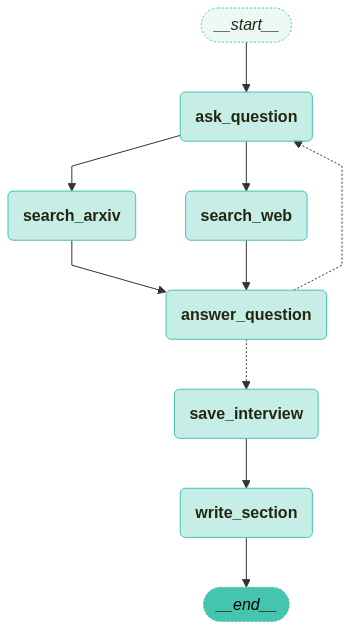

In [219]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 노드 및 엣지 추가
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_arxiv", search_arxiv)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# 흐름 설정
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_arxiv")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_arxiv", "answer_question")
interview_builder.add_conditional_edges(
    "answer_question", route_messages, ["ask_question", "save_interview"]
)
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# 인터뷰 그래프 생성
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(
    run_name="Conduct Interviews"
)

# 그래프 시각화
visualize_graph(interview_graph)


In [220]:
# 분석가 목록에서 첫 번째 분석가 선택
analysts[0]


Analyst(affiliation='Independent Researcher', name='Dr. Hannah Kim', role='Academic Specialist', description='Dr. Kim is an academic researcher with a focus on machine learning frameworks and their applications in real-world scenarios. She is particularly interested in comparing Modular RAG and Naive RAG in terms of flexibility and efficiency for handling complex data requirements in production settings.')

In [221]:
from IPython.display import Markdown

# 주제 설정
topic = "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점"

# 인터뷰 시작 메시지 생성
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]

# 스레드 ID 설정
config = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": random_uuid()},
)

# 그래프 실행
invoke_graph(
    interview_graph,
    {"analyst": analysts[0], "messages": messages, "max_num_turns": 5},
    config,
)



🔄 Node: ask_question 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello, Dr. Kim. My name is Alex Thompson, and I'm an analyst deeply interested in the practical applications of machine learning frameworks, particularly Modular RAG and Naive RAG. I'm eager to understand the differences between these two frameworks, especially in terms of their flexibility and efficiency in handling complex data requirements in production settings. Could you please elaborate on these aspects for us?

🔄 Node: search_arxiv 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<Document source="http://arxiv.org/abs/2508.05650v1" date="2025-07-26" authors="Jiaxuan Liang, Shide Zhou, Kailong Wang"/>
<Title>
OmniBench-RAG: A Multi-Domain Evaluation Platform for Retrieval-Augmented Generation Tools
</Title>

<Summary>
While Retrieval Augmented Generation (RAG) is now widely adopted to enhance
LLMs, evaluating its true per

In [222]:
# 완성된 인터뷰 섹션 출력
Markdown(interview_graph.get_state(config).values["sections"][0])


## Evaluating the Flexibility and Efficiency of Modular RAG vs. Naive RAG

### Summary

In the rapidly advancing field of machine learning, Retrieval-Augmented Generation (RAG) frameworks have become pivotal in enhancing the capabilities of Large Language Models (LLMs), especially in complex data scenarios. Dr. Kim, an academic researcher with a special focus on machine learning frameworks, delves into a critical comparison of Modular RAG and Naive RAG, analyzing their flexibility and efficiency in production settings. The insights gathered offer novel perspectives on the adaptability and performance of these frameworks across different domains.

RAG is designed to mitigate the typical issues faced by LLMs, such as hallucinations and factual inaccuracies, by grounding responses in retrievable external knowledge [1]. The conventional Naive RAG functions through a simple mechanism of retrieving and leveraging relevant documents for generation tasks. However, as highlighted in recent evaluations, Naive RAG's lack of flexibility often leads to inefficiencies, especially in adapting to diverse domain requirements [2]. This has paved the way for Modular RAG, which breaks down the RAG process into separable modules, offering greater adaptability and precision [3].

In their comprehensive evaluation, Liang and colleagues introduce OmniBench RAG, a platform that further exemplifies how Modular RAG can be leveraged to assess RAG systems across multiple domains with precision [4]. On the other hand, frameworks such as Vendi-RAG demonstrate how dynamic integration and iterative processes can enhance RAG’s performance by balancing retrieval diversity and answer quality [5]. 

Emerging research emphasizes the need for a modular approach, which is agile not just in technical performance but also in handling various complexities inherent in real-world scenarios. Such findings underscore the critical role of modular architectures in optimizing RAG's effectiveness when applied to intricate, domain-specific applications.

Sources:
1. [2] https://medium.com/@drjulija/what-are-naive-rag-advanced-rag-modular-rag-paradigms-edff410c202e
2. [2] https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/
3. [2] https://blog.searce.com/unlocking-the-power-of-llm-rag-discover-naive-advanced-and-modular-retrieval-augmented-6922b353d8d3
4. [1] http://arxiv.org/abs/2508.05650v1
5. [4] http://arxiv.org/abs/2502.11228v2

### Comprehensive Analysis

#### 1. Introduction to RAG Frameworks

Retrieval-Augmented Generation (RAG) frameworks represent a fusion of information retrieval and natural language generation, enhancing LLMs' competence by accessing external information sources. This aspect is crucial for Dr. Kim’s interest since RAG systems address foundational challenges, such as large context window limitations and the need for real-time factual accuracy [4]. While Naive RAG follows a monolithic structure, Modular RAG emerges as a flexible paradigm by decomposing the processes into specialized, interchangeable modules [2].

#### 2. Naive RAG: Strengths and Limitations

The Naive RAG framework begins with straightforward indexing and retrieval, relying heavily on the relevance of documents to input queries [2]. It functions efficiently in environments requiring a basic level of retrieval and generation without complex modular demands. However, its static nature becomes a liability in dynamic production settings where rapid adaptability is required:

- **Efficiency Concerns**: Naive RAG lacks agility, making it less efficient in handling diverse data requirements. As tasks become complex, the framework's inefficiencies in integrating retrieval and generation processes lead to increased latency and possible incorrect outputs [3].

- **Integration Challenges**: The monolithic framework restricts seamless integration with advanced retrieval systems, hindering its effectiveness in scaling across different domains [3].

#### 3. Modular RAG: Advancements and Benefits

The Modular RAG framework represents a significant shift towards configurable and scalable AI systems. By segregating retrieval, reasoning, and generation into distinct components, it addresses many of the efficiency challenges associated with Naive RAG [2]:

- **Enhanced Flexibility**: Modular RAG's ability to interchange modules allows it to tailor components specifically to domain requirements, ensuring a higher degree of accuracy and relevance in generated responses [2].

- **Scalable Architecture**: The framework’s architecture supports a variety of retrieval mechanisms, such as Elasticsearch, enhancing its efficacy in diverse production environments [6].

- **Superior Performance Metrics**: Tools like OmniBench RAG illustrate how Modular RAG's architecture can be utilized for systematic performance evaluations across domains, highlighting significant gains in areas like cultural data and efficiency drops in domains like mathematics [4].

#### 4. Comparative Evaluations and Domain Applications

By leveraging advanced platform evaluations like OmniBench RAG, the nuanced differences in RAG systems can be quantified. The introduction of standardized metrics – Improvements and Transformation – allows for reproducible comparisons, providing deep insights into the respective capabilities of Modular versus Naive RAG:

- **Domain-Specific Evaluation**: Modular RAG demonstrates significant improvements in knowledge-intensive and domain-specific tasks due to its modular nature, allowing for precise evaluations and scalability [4].

- **Iterative Improvements**: Frameworks like Vendi-RAG that incorporate iterative methods further demonstrate the adaptability and improved performance of Modular RAG under strenuous conditions [5].

In conclusion, the comprehensive analysis underscores Modular RAG's superiority in managing complex, evolving data requirements in production settings, ultimately advocating for its broader adoption in scenarios demanding high adaptability and efficiency. Dr. Kim would likely find Modular RAG to be the favorable choice for its robustness, agility, and precision across varying domains.

### Sources
[1] http://arxiv.org/abs/2508.05650v1  
[2] https://medium.com/@drjulija/what-are-naive-rag-advanced-rag-modular-rag-paradigms-edff410c202e  
[3] https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/  
[4] http://arxiv.org/abs/2502.11228v2  
[5] https://blog.searce.com/unlocking-the-power-of-llm-rag-discover-naive-advanced-and-modular-retrieval-augmented-6922b353d8d3  
[6] https://dextralabs.com/blog/rag-pipeline-explained-diagram-implementation/  

In [223]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


# ResearchGraphState 상태 정의
class ResearchGraphState(TypedDict):
    # 연구 주제
    topic: str
    # 생성할 분석가의 최대 수
    max_analysts: int
    # 인간 분석가의 피드백
    human_analyst_feedback: str
    # 질문을 하는 분석가 목록
    analysts: List[Analyst]
    # Send() API 키를 포함하는 섹션 리스트
    sections: Annotated[list, operator.add]
    # 최종 보고서의 서론
    introduction: str
    # 최종 보고서의 본문 내용
    content: str
    # 최종 보고서의 결론
    conclusion: str
    # 최종 보고서
    final_report: str


In [224]:
from langgraph.constants import Send


# 모든 인터뷰를 시작
def initiate_all_interviews(state: ResearchGraphState):
    # 사람의 피드백 확인
    human_analyst_feedback = state.get("human_analyst_feedback")

    # 만약, 사람의 피드백이 있으면 분석가 생성으로 돌아가기
    if human_analyst_feedback:
        return "create_analysts"

    # 그렇지 않으면 Send() 함수를 통해 인터뷰 병렬로 시작
    else:
        topic = state["topic"]
        return [
            Send(
                "conduct_interview",
                {
                    "analyst": analyst,
                    "messages": [
                        HumanMessage(
                            content=f"So you said you were writing an article on {topic}?"
                        )
                    ],
                },
            )
            for analyst in state["analysts"]
        ]


/var/folders/sj/3r49bs6178v7nfhcxh7lpzd80000gn/T/ipykernel_43129/556175951.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [225]:
# 보고서 작성 지시사항
report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.  
2. Carefully review and analyze the insights from each memo.  
3. Consolidate these insights into a detailed and comprehensive summary that integrates the central ideas from all the memos.  
4. Organize the key points from each memo into the appropriate sections provided below, ensuring that each section is logical and well-structured.  
5. Include all required sections in your report, using `### Section Name` as the header for each.  
6. Aim for approximately 250 words per section, providing in-depth explanations, context, and supporting details.  

**Sections to consider (including optional ones for greater depth):**

- **Background**: Theoretical foundations, key concepts, and preliminary information necessary to understand the methodology and results.
- **Related Work**: Overview of prior studies and how they compare or relate to the current research.
- **Problem Definition**: A formal and precise definition of the research question or problem the paper aims to address.
- **Methodology (or Methods)**: Detailed description of the methods, algorithms, models, data collection processes, or experimental setups used in the study.
- **Implementation Details**: Practical details of how the methods or models were implemented, including software frameworks, computational resources, or parameter settings.
- **Experiments**: Explanation of experimental protocols, datasets, evaluation metrics, procedures, and configurations employed to validate the methods.
- **Results**: Presentation of experimental outcomes, often with statistical tables, graphs, figures, or qualitative analyses.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""


# 보고서 작성 함수 정의
def write_report(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 최종 보고서 작성
    system_message = report_writer_instructions.format(
        topic=topic, context=formatted_str_sections
    )
    report = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Write a report based upon these memos.")]
    )
    return {"content": report.content}


# 서론과 결론 작성 지시사항
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 200 words, crisply previewing (for introduction),  or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


# 서론 작성 함수 정의
def write_introduction(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 서론 작성
    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    intro = llm.invoke(
        [instructions] + [HumanMessage(content=f"Write the report introduction")]
    )
    return {"introduction": intro.content}


# 결론 작성 함수 정의
def write_conclusion(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 결론 작성
    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    conclusion = llm.invoke(
        [instructions] + [HumanMessage(content=f"Write the report conclusion")]
    )
    return {"conclusion": conclusion.content}


# 최종 보고서 작성 함수 정의
def finalize_report(state: ResearchGraphState):
    # 모든 섹션을 모아 최종 보고서 작성
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = (
        state["introduction"]
        + "\n\n---\n\n## Main Idea\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}


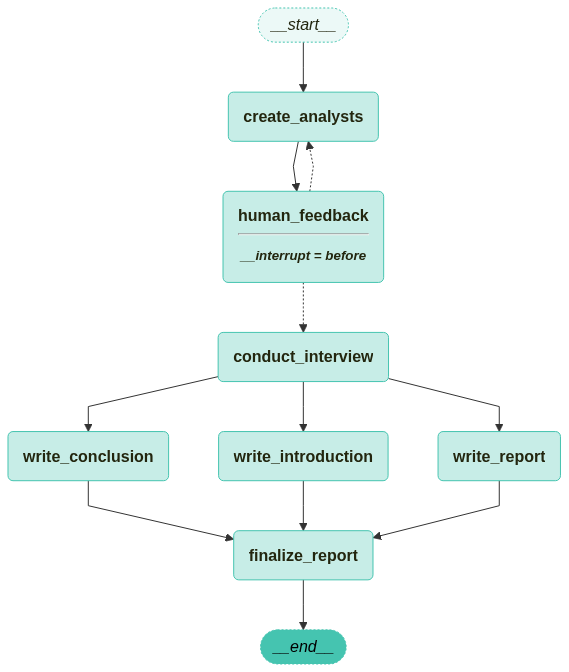

In [226]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START, END
from langchain_teddynote.graphs import visualize_graph

# 그래프 생성
builder = StateGraph(ResearchGraphState)

# 노드 정의
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# 엣지 정의
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"]
)

# 인터뷰 결과 보고서 작성
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")

# 보고서 최종 정리
builder.add_edge(
    ["write_conclusion", "write_report", "write_introduction"], "finalize_report"
)
builder.add_edge("finalize_report", END)

# 컴파일
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

visualize_graph(graph)


In [227]:
# 입력 데이터 설정
max_analysts = 3
topic = "Explain how Modular RAG differs from traditional Naive RAG and the benefits of using it at the production level."

# config 설정
config = RunnableConfig(
    recursion_limit=30,
    configurable={"thread_id": random_uuid()},
)

# 입력 데이터 설정
inputs = {"topic": topic, "max_analysts": max_analysts}

# 그래프 실행: 첫 번째 중단 지점까지
invoke_graph(graph, inputs, config)



🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Tech Innovations Journal' name='Alice Turing' role='Data Science Researcher' description='Alice is focused on understanding the technological advancements and practical implementations in data science. Her primary concern is how new methodologies, like Modular RAG, provide scalable and efficient solutions compared to traditional methods such as Naive RAG. Alice is motivated by the potential of modular systems to improve adaptability in rapidly changing environments.'
affiliation='Production Efficiency Solutions Inc.' name='Mohammed Sinclair' role='Operations Analyst' description='Mohammed examines the benefits of Modular RAG over Naive RAG at the production level, primarily looking at operational efficiency and cost-effectiveness. His focus is on how modularity can lead to reduced downtime and better resource allocation in production environments. Mohammed is driven by finding solutions that redu

In [228]:
# 새로운 분석가 추가
graph.update_state(
    config,
    {"human_analyst_feedback": "Add Prof. Jeffrey Hinton as a head of AI analyst"},
    as_node="human_feedback",
)


{'configurable': {'thread_id': '56d6c5d3-51f2-4c1b-b859-3eefcb4d2eb3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f083d3b-644b-6600-8002-8769af338823'}}

In [229]:
# 그래프 실행
invoke_graph(graph, None, config)



🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Vector Institute' name='Prof. Jeffrey Hinton' role='Head of AI Analyst' description='As the head of AI analysts, Prof. Hinton brings a pioneering perspective on deep learning and neural networks. He is particularly interested in how Modular RAG can improve efficiency and scalability over Naive RAG, and what implications this has for advancing AI in production environments.'
affiliation='OpenAI' name='Dr. Lisa Torres' role='Scalability Specialist' description='Dr. Torres focuses on the scalability benefits of Modular RAG versus Naive RAG. Her analysis centers around how Modular RAG can handle larger datasets more efficiently and its adaptability to various production-level scenarios.'
affiliation='DeepMind' name='Dr. Amir Kahn' role='Performance Analyst' description="Dr. Kahn's expertise lies in evaluating the performance metrics of AI models. He compares Modular and Naive RAG in terms of speed an

In [230]:
# 그래프 재개
graph.update_state(config, {"human_analyst_feedback": None}, as_node="human_feedback")


{'configurable': {'thread_id': '56d6c5d3-51f2-4c1b-b859-3eefcb4d2eb3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f083d3b-7e43-6c88-8004-c644448fdcc5'}}

In [231]:
# 그래프 실행
invoke_graph(graph, None, config)



🔄 Node: ask_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello, I'm John Harper, a technology writer exploring cutting-edge advancements in AI scalability. Dr. Torres, could you please explain how Modular RAG differs from traditional Naive RAG, specifically in terms of scalability and handling large datasets? How does modularity enhance its performance in production environments?

🔄 Node: ask_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello, Dr. Kahn, my name is Alex Ramirez, and I'm a technology journalist interested in exploring advancements in AI performance metrics. I'm particularly intrigued by the differences between Modular RAG and Naive RAG. Could you provide an explanation of how these two approaches differ specifically, and what bene

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-Soffyuxth7vsUnobnzk0MGeR on tokens per min (TPM): Limit 30000, Used 29334, Requested 11245. Please try again in 21.158s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [234]:
from IPython.display import Markdown

# 그래프의 최종 상태 가져오기
final_state = graph.get_state(config)

# 최종 보고서 가져오기
report = final_state.values.get("final_report")

# 마크다운 형식으로 최종 보고서 출력
display(Markdown(report))


<IPython.core.display.Markdown object>